<a href="https://colab.research.google.com/github/regizus/ThickenersModelling/blob/main/tailingsThickeners.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introducción, descripción de las metas del proyecto

El proyecto en la forma actual está prediciendo comportamiento de espesador de relaves de una planta concentradora en base de:
* los datos sobre el mineral alimentado de la mina, 
* las variables operacionaels de molienda,
* división de carga entre los espesadores
* condición actual del espesador (variavles operacionales).

En la forma actual, se prepara el modelo prediciendo un label que combina datos de los sólidos de descarga (el _objective_ del proces del espesador) con datos del torque de la rastra del espesador (un factor fisico limitante la operación).

El archivo Excel con los datos iniciales se prepara considerando los desfases de tiempo entre los datos de la mina, de molienda y de los espesadores. 

Además, el archivo contiene datos de 2 espesadores de relaves. Los 2 espesadores operan en paralelo. En el etapa actual solo se modela operación de 1 de los 2 espesadores, pero **el notebook será desarrollado después del final del curso, como un proyecto para mi empleador**. Por lo tanto, el archivo inicial contiene un set de datos más grande que lo que se utiliza para el modelamiento. También el preprocesamiento considera datos para ambos espesadores.

La meta del proyecto para el curso se define como: 
* preprocesar los datos de ambos espesadores
* buscar configuraciones optimas para modelar el proceso del **_Espesador 1_** usando algoritmos Random Forest y KNN
* revisar y comparar las metricas de los modelos optimos
* sacar conclusiones, definir cosas para mejorar para los próximos pasos de desarrollo.

La meta final, para el futuro:
* prepara modelos de buena calidad (con valores aceptables de todas las metricas aplicadas) de ambos espesadores de relaves,
* utilizar los modelos para generar recomendaciones de control de los SetPoint de **_Profundidad Agua Clara_** y **_GPT de Floculante_** para los lazos de contror implementados en los sistemas de control y de control avanzado de la planta concentradora.



#Importar librerias

Se importa las librerías necesarias. Se deshabilita un tipo de warning de Pandas, para recibir resultados del procesamiento más limpios.

In [ ]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn import tree

from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.cluster import KMeans

#%matplotlib notebook

In [ ]:
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.width', 1000)

#Cargar archivo. Visualizar, estudiar y limpiar dataframe.

##Carga del archivo

Excel file contains data downloaded form OSI PI database.

Future versions of this notebook will have an implementation of a direct connection to said database as an alternative to the use of Excel file.

In [ ]:
DBurl = '/content/drive/MyDrive/Colab Notebooks/tailings thickeners modelling/Excel/DBv3.xlsx'
initDB = df = pd.read_excel(DBurl, sheet_name='data')

##Estudio y limpieza inicial del dataframe fuente

###Se visualiza los atributos

In [ ]:
initDB.head()

,timestamp [end mean],mineral alteracion 301,mineral alteracion 304,mineral alteracion 306,BWI %,Clay %,mineral LITO 110,mineral LITO 122,mineral LITO 132,mineral LITO 137,mineral LITO 151,mineral LITO 152,mineral LITO INT,mineral UGM 800,mineral UGM 802,mineral UGM 810,mineral UGM 820,mineral UGM 830,mineral UGM 840,mineral UGM 850,mineral UGM 855,mineral UGM 890,mineral ZOCU 241,mineral ZOCU 242,mineral ZOCU 243,Nivel Stock Pile,TPH molienda,TPH molino 1,TPH molino 2,TPH molino 3,P80 Molino 1,P80 Molino 2,P80 Molino 3,flujo másico alim Esp1,flujo másico alim Esp2,Profundidad agua clara Esp1,Profundidad agua clara Esp2,Sólidos PP-11,Sólidos PP-21,Sólidos PP-12,Sólidos PP-22,Sólidos PP-11 old,Sólidos PP-21 old,Sólidos PP-12 old,Sólidos PP-22 old,Flujo PP-11,Flujo PP-21,Flujo PP-12,Flujo PP-22,velocidad PP-11,velocidad PP-21,velocidad PP-12,velocidad PP-22,Torque Rastra Esp1,Torque Rastra Esp2,Presión Cono Esp1,Presión Cono Esp2,Balance mineral Esp1,Balance mineral Esp2,Floculante GPT Esp1,Floculante GPT Esp2,Profundidad Cama Esp1,Profundidad Barro Esp1,Profundidad Interface Esp1,Profundidad Cama Esp2,Profundidad Barro Esp2,Profundidad Interface Esp2
0,2021-01-01 00:10:00,64,35,0,16.144802,2.318361,100,0,0,0,0,0,0,0,0,0,0,100,0,0,0,0,0,42,57,74.769595,3639.833365,1967.311274,0,1672.568733,171.572927,261.953186,120.922558,1753.541141,1753.541141,3.8781,2.511776,[-11059] No Good Data For Calculation,[-11059] No Good Data For Calculation,[-11059] No Good Data For Calculation,[-11059] No Good Data For Calculation,59.913415,58.508924,58.41212,57.96091,817.63383,908.238367,[-11059] No Good Data For Calculation,[-11059] No Good Data For Calculation,57.996315,59.002788,56.997282,56.999296,41.215111,37.702733,26.301266,34.230404,68.750905,37.354947,7.98554,10.874531,4.692602,4.396193,4.351076,[-11059] No Good Data For Calculation,[-11059] No Good Data For Calculation,[-11059] No Good Data For Calculation
1,2021-01-01 00:20:00,64,35,0,16.144802,2.318361,100,0,0,0,0,0,0,0,0,0,0,100,0,0,0,0,0,42,57,75.228864,3634.499422,1978.481303,0,1655.906792,169.046286,261.953186,177.56663,1784.87276,1784.87276,3.913801,2.5437,[-11059] No Good Data For Calculation,[-11059] No Good Data For Calculation,[-11059] No Good Data For Calculation,[-11059] No Good Data For Calculation,59.721445,58.278829,58.231881,57.945735,776.197126,899.209398,[-11059] No Good Data For Calculation,[-11059] No Good Data For Calculation,57.999652,58.997755,57.002228,56.998618,40.878397,38.421184,26.295316,33.969934,160.034126,127.171649,7.937909,10.799016,4.670515,4.415126,4.36885,[-11059] No Good Data For Calculation,[-11059] No Good Data For Calculation,[-11059] No Good Data For Calculation
2,2021-01-01 00:30:00,64,35,0,16.144802,2.318361,100,0,0,0,0,0,0,0,0,0,0,100,0,0,0,0,0,42,57,76.01595,3538.479857,1947.453813,0,1590.958965,201.278013,261.953186,194.838442,1785.07512,1785.07512,3.920572,2.578081,[-11059] No Good Data For Calculation,[-11059] No Good Data For Calculation,[-11059] No Good Data For Calculation,[-11059] No Good Data For Calculation,59.700201,58.377124,57.914326,57.850791,768.897887,856.879475,[-11059] No Good Data For Calculation,[-11059] No Good Data For Calculation,58.00318,59.004909,56.99798,56.998439,40.284472,38.083284,26.200436,33.671426,218.634609,181.784366,7.992967,10.787583,4.623,4.453,4.384,[-11059] No Good Data For Calculation,[-11059] No Good Data For Calculation,[-11059] No Good Data For Calculation
3,2021-01-01 00:40:00,64,35,0,16.144802,2.318361,100,0,0,0,0,0,0,0,0,0,0,100,0,0,0,0,0,42,57,75.251706,3679.830122,2058.348387,0,1621.896036,172.288293,261.953186,202.28466,1768.910564,1768.910564,3.9198,2.59853,[-11059] No Good Data For Calculation,[-11059] No Good Data For Calculation,[-11059] No Good Data For Calculation,[-11059] No Good Data For Calculation,59.654947,58.255038,57.707589,57.690915,778.316327,909.001349,[-11059] No Good Data For Calculation,[-11059] No Good Data For Calculation,58.00558,59.00011,56.995673,56.996835,39.955379,37.492

In [ ]:
initDB.columns

Index(['timestamp [end mean]', 'mineral alteracion 301', 'mineral alteracion 304', 'mineral alteracion 306', 'BWI %', 'Clay %', 'mineral LITO 110', 'mineral LITO 122', 'mineral LITO 132', 'mineral LITO 137', 'mineral LITO 151', 'mineral LITO 152', 'mineral LITO INT', 'mineral UGM 800', 'mineral UGM 802', 'mineral UGM 810', 'mineral UGM 820', 'mineral UGM 830', 'mineral UGM 840', 'mineral UGM 850', 'mineral UGM 855', 'mineral UGM 890', 'mineral ZOCU 241', 'mineral ZOCU 242', 'mineral ZOCU 243', 'Nivel Stock Pile', 'TPH molienda', 'TPH molino 1', 'TPH molino 2', 'TPH molino 3', 'P80 Molino 1', 'P80 Molino 2', 'P80 Molino 3', 'flujo másico alim Esp1', 'flujo másico alim Esp2', 'Profundidad agua clara Esp1', 'Profundidad agua clara Esp2', 'Sólidos PP-11', 'Sólidos PP-21', 'Sólidos PP-12', 'Sólidos PP-22', 'Sólidos PP-11 old', 'Sólidos PP-21 old', 'Sólidos PP-12 old', 'Sólidos PP-22 old', 'Flujo PP-11', 'Flujo PP-21', 'Flujo PP-12', 'Flujo PP-22', 'velocidad PP-11', 'velocidad PP-21',
     

Dropping SmartDiver data for both thickeners, due to low quality of measurements.

In [ ]:
initDB.drop(['Profundidad Cama Esp1', 'Profundidad Barro Esp1',
             'Profundidad Interface Esp1', 'Profundidad Cama Esp2',
             'Profundidad Barro Esp2', 'Profundidad Interface Esp2'], axis = 1, inplace = True)

###Se revisa tipos de atributos. Se corrige tipos incorrectos

Se revisa tipos de atributos. Timestamp debe ser de tipo datetime, los otros deben ser de tipos númericos.

In [ ]:
initDB.dtypes

timestamp [end mean]           datetime64[ns]
mineral alteracion 301                 object
mineral alteracion 304                 object
mineral alteracion 306                 object
BWI %                                  object
Clay %                                 object
mineral LITO 110                       object
mineral LITO 122                       object
mineral LITO 132                       object
mineral LITO 137                       object
mineral LITO 151                       object
mineral LITO 152                       object
mineral LITO INT                       object
mineral UGM 800                        object
mineral UGM 802                        object
mineral UGM 810                        object
mineral UGM 820                        object
mineral UGM 830                        object
mineral UGM 840                        object
mineral UGM 850                        object
mineral UGM 855                        object
mineral UGM 890                   

Se encuentra unos atributos de tipo object. Se genera una lista de atributos para corregir.

In [ ]:
DBobjects = list(initDB.select_dtypes(include=['object']).columns)
#DBobjects.remove('timestamp [end mean]')
DBobjects

['mineral alteracion 301',
 'mineral alteracion 304',
 'mineral alteracion 306',
 'BWI %',
 'Clay %',
 'mineral LITO 110',
 'mineral LITO 122',
 'mineral LITO 132',
 'mineral LITO 137',
 'mineral LITO 151',
 'mineral LITO 152',
 'mineral LITO INT',
 'mineral UGM 800',
 'mineral UGM 802',
 'mineral UGM 810',
 'mineral UGM 820',
 'mineral UGM 830',
 'mineral UGM 840',
 'mineral UGM 850',
 'mineral UGM 855',
 'mineral UGM 890',
 'mineral ZOCU 241',
 'mineral ZOCU 242',
 'mineral ZOCU 243',
 'Nivel Stock Pile',
 'TPH molienda',
 'TPH molino 1',
 'TPH molino 2',
 'TPH molino 3',
 'P80 Molino 1',
 'P80 Molino 2',
 'P80 Molino 3',
 'flujo másico alim Esp1',
 'flujo másico alim Esp2',
 'Profundidad agua clara Esp1',
 'Profundidad agua clara Esp2',
 'Sólidos PP-11',
 'Sólidos PP-21',
 'Sólidos PP-12',
 'Sólidos PP-22',
 'Sólidos PP-11 old',
 'Sólidos PP-21 old',
 'Sólidos PP-12 old',
 'Sólidos PP-22 old',
 'Flujo PP-11',
 'Flujo PP-21',
 'Flujo PP-12',
 'Flujo PP-22',
 'velocidad PP-11',
 'velo

Se define el string generado en el Excel en caso de algún problema con los datos. Se lo reemplaza con NaN.

In [ ]:
strToNaN = '[-11059] No Good Data For Calculation'
initDB = initDB.replace(strToNaN, np.nan)

Se cambia los atributos tipo object (string) a tipo float. De esta manera se homogeniza los tipos de atributos.

In [ ]:
initDB[DBobjects] = initDB[DBobjects].astype(float)
#initDB[DBobjects] = pd.to_numeric(initDB[DBobjects], errors='coerce')

Se vuelve a revisar los tipos de atributos, para asegurarse que todo fue bien con la homogenización.

In [ ]:
initDB.dtypes

timestamp [end mean]           datetime64[ns]
mineral alteracion 301                float64
mineral alteracion 304                float64
mineral alteracion 306                float64
BWI %                                 float64
Clay %                                float64
mineral LITO 110                      float64
mineral LITO 122                      float64
mineral LITO 132                      float64
mineral LITO 137                      float64
mineral LITO 151                      float64
mineral LITO 152                      float64
mineral LITO INT                      float64
mineral UGM 800                       float64
mineral UGM 802                       float64
mineral UGM 810                       float64
mineral UGM 820                       float64
mineral UGM 830                       float64
mineral UGM 840                       float64
mineral UGM 850                       float64
mineral UGM 855                       float64
mineral UGM 890                   

In [ ]:
pd.isna(initDB).sum()

timestamp [end mean]               0
mineral alteracion 301          2014
mineral alteracion 304          2014
mineral alteracion 306          2014
BWI %                           2014
Clay %                          2014
mineral LITO 110                2014
mineral LITO 122                2014
mineral LITO 132                2014
mineral LITO 137                2014
mineral LITO 151                2014
mineral LITO 152                2014
mineral LITO INT                2014
mineral UGM 800                 2014
mineral UGM 802                 2014
mineral UGM 810                 2014
mineral UGM 820                 2014
mineral UGM 830                 2014
mineral UGM 840                 2014
mineral UGM 850                 2014
mineral UGM 855                 2014
mineral UGM 890                 2014
mineral ZOCU 241                2014
mineral ZOCU 242                2014
mineral ZOCU 243                2014
Nivel Stock Pile                 186
TPH molienda                     167
T

In [ ]:
initDB.shape

(78618, 61)

### Calculating and filling missing data where it's possible

In [ ]:
initDB['TPH molienda calculado'] = initDB['TPH molino 1'] + initDB['TPH molino 2'] + initDB['TPH molino 3']
initDB['TPH molienda'] = initDB['TPH molienda'].fillna(initDB['TPH molienda calculado'])
initDB.drop(['TPH molienda calculado'], axis = 1, inplace = True)

In [ ]:
initDB['Sólidos PP-11'] = initDB['Sólidos PP-11'].fillna(initDB['Sólidos PP-11 old'])
initDB['Sólidos PP-21'] = initDB['Sólidos PP-21'].fillna(initDB['Sólidos PP-21 old'])
initDB['Sólidos PP-12'] = initDB['Sólidos PP-12'].fillna(initDB['Sólidos PP-12 old'])
initDB['Sólidos PP-22'] = initDB['Sólidos PP-22'].fillna(initDB['Sólidos PP-22 old'])
initDB.drop(['Sólidos PP-11 old', 'Sólidos PP-21 old', 'Sólidos PP-12 old', 'Sólidos PP-22 old'], axis = 1, inplace = True)

Equations for flow rate models were generated via regression in MiniTab

Dynamic modelling/regression will be implemented in future version of this notebook

In [ ]:
initDB['Flujo PP-11 calculado'] = 88.43 \
                                + 10.636 * initDB['velocidad PP-11'] \
                                - 1.379 * initDB['Sólidos PP-11'] \
                                + 0.20378 * initDB['velocidad PP-11'] * initDB['velocidad PP-11'] \
                                - 0.09658 * initDB['Sólidos PP-11'] * initDB['Sólidos PP-11'] \
                                + 0.06756 * initDB['velocidad PP-11'] * initDB['Sólidos PP-11']

initDB['Flujo PP-21 calculado'] = -0.03 \
                                + 10.118 * initDB['velocidad PP-21'] \
                                - 0.607 * initDB['Sólidos PP-21'] \
                                + 0.23033 * initDB['velocidad PP-21'] * initDB['velocidad PP-21'] \
                                + 0.000295 * initDB['Sólidos PP-21'] * initDB['Sólidos PP-21'] \
                                - 0.05248 * initDB['velocidad PP-21'] * initDB['Sólidos PP-21']

initDB['Flujo PP-12 calculado'] = -23.66 \
                                + 17.703 * initDB['velocidad PP-12'] \
                                - 0.1695 * initDB['Sólidos PP-12'] \
                                + 0.15902 * initDB['velocidad PP-12'] * initDB['velocidad PP-12'] \
                                - 0.000038 * initDB['Sólidos PP-12'] * initDB['Sólidos PP-12'] \
                                - 0.06868 * initDB['velocidad PP-12'] * initDB['Sólidos PP-12']

initDB['Flujo PP-22 calculado'] = 0.05 \
                                + 17.345 * initDB['velocidad PP-22'] \
                                - 1.617 * initDB['Sólidos PP-22'] \
                                + 0.13699 * initDB['velocidad PP-22'] * initDB['velocidad PP-22'] \
                                + 0.001144 * initDB['Sólidos PP-22'] * initDB['Sólidos PP-22'] \
                                - 0.04126 * initDB['velocidad PP-22'] * initDB['Sólidos PP-22']

initDB['Flujo PP-11'] = initDB['Flujo PP-11'].fillna(initDB['Flujo PP-11 calculado'])
initDB['Flujo PP-21'] = initDB['Flujo PP-21'].fillna(initDB['Flujo PP-21 calculado'])
initDB['Flujo PP-12'] = initDB['Flujo PP-12'].fillna(initDB['Flujo PP-12 calculado'])
initDB['Flujo PP-22'] = initDB['Flujo PP-22'].fillna(initDB['Flujo PP-22 calculado'])

initDB.drop(['Flujo PP-11 calculado', 'Flujo PP-21 calculado', 'Flujo PP-12 calculado', 'Flujo PP-22 calculado'], axis = 1, inplace = True)

### Generating ROC (Rate Of Change) values to save information abour sinal dynamics

In [ ]:
initDB.head()

,timestamp [end mean],mineral alteracion 301,mineral alteracion 304,mineral alteracion 306,BWI %,Clay %,mineral LITO 110,mineral LITO 122,mineral LITO 132,mineral LITO 137,mineral LITO 151,mineral LITO 152,mineral LITO INT,mineral UGM 800,mineral UGM 802,mineral UGM 810,mineral UGM 820,mineral UGM 830,mineral UGM 840,mineral UGM 850,mineral UGM 855,mineral UGM 890,mineral ZOCU 241,mineral ZOCU 242,mineral ZOCU 243,Nivel Stock Pile,TPH molienda,TPH molino 1,TPH molino 2,TPH molino 3,P80 Molino 1,P80 Molino 2,P80 Molino 3,flujo másico alim Esp1,flujo másico alim Esp2,Profundidad agua clara Esp1,Profundidad agua clara Esp2,Sólidos PP-11,Sólidos PP-21,Sólidos PP-12,Sólidos PP-22,Flujo PP-11,Flujo PP-21,Flujo PP-12,Flujo PP-22,velocidad PP-11,velocidad PP-21,velocidad PP-12,velocidad PP-22,Torque Rastra Esp1,Torque Rastra Esp2,Presión Cono Esp1,Presión Cono Esp2,Balance mineral Esp1,Balance mineral Esp2,Floculante GPT Esp1,Floculante GPT Esp2
0,2021-01-01 00:10:00,64.0,35.0,0.0,16.144802,2.318361,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,42.0,57.0,74.769595,3639.833365,1967.311274,0.0,1672.568733,171.572927,261.953186,120.922558,1753.541141,1753.541141,3.878100,2.511776,59.913415,58.508924,58.412120,57.960910,817.633830,908.238367,1263.280565,1207.580804,57.996315,59.002788,56.997282,56.999296,41.215111,37.702733,26.301266,34.230404,68.750905,37.354947,7.985540,10.874531
1,2021-01-01 00:20:00,64.0,35.0,0.0,16.144802,2.318361,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,42.0,57.0,75.228864,3634.499422,1978.481303,0.0,1655.906792,169.046286,261.953186,177.566630,1784.872760,1784.872760,3.913801,2.543700,59.721445,58.278829,58.231881,57.945735,776.197126,899.209398,1264.174902,1207.618294,57.999652,58.997755,57.002228,56.998618,40.878397,38.421184,26.295316,33.969934,160.034126,127.171649,7.937909,10.799016
2,2021-01-01 00:30:00,64.0,35.0,0.0,16.144802,2.318361,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,42.0,57.0,76.015950,3538.479857,1947.453813,0.0,1590.958965,201.278013,261.953186,194.838442,1785.075120,1785.075120,3.920572,2.578081,59.700201,58.377124,57.914326,57.850791,768.897887,856.879475,1265.338009,1207.977038,58.003180,59.004909,56.997980,56.998439,40.284472,38.083284,26.200436,33.671426,218.634609,181.784366,7.992967,10.787583
3,2021-01-01 00:40:00,64.0,35.0,0.0,16.144802,2.318361,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,42.0,57.0,75.251706,3679.830122,2058.348387,0.0,1621.896036,172.288293,261.953186,202.284660,1768.910564,1768.910564,3.919800,2.598530,59.654947,58.255038,57.707589,57.690915,778.316327,909.001349,1266.109760,1208.541358,58.005580,59.000110,56.995673,56.996835,39.955379,37.492025,26.141259,33.797216,206.600519,199.885110,7.994009,10.672919
4,2021-01-01 00:50:00,64.0,35.0,0.0,16.144802,2.318361,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,42.0,57.0,75.387341,3806.745915,2156.614422,0.0,1650.230780,172.929961,261.953186,203.938209,1811.498083,1811.498083,3.917263,2.618025,59.341038,58.136612,57.559187,57.476995,816.590945,915.582342,1266.941299,1209.442439,57.997999,58.995935,57.002726,56.999459,39.295915,38.313324,26.193838,33.636627,235.701665,265.611408,8.035705,10.224858


In [ ]:
initDB_ROC10m = initDB.diff(periods=1, axis=0)
initDB_ROC10m.head()

,timestamp [end mean],mineral alteracion 301,mineral alteracion 304,mineral alteracion 306,BWI %,Clay %,mineral LITO 110,mineral LITO 122,mineral LITO 132,mineral LITO 137,mineral LITO 151,mineral LITO 152,mineral LITO INT,mineral UGM 800,mineral UGM 802,mineral UGM 810,mineral UGM 820,mineral UGM 830,mineral UGM 840,mineral UGM 850,mineral UGM 855,mineral UGM 890,mineral ZOCU 241,mineral ZOCU 242,mineral ZOCU 243,Nivel Stock Pile,TPH molienda,TPH molino 1,TPH molino 2,TPH molino 3,P80 Molino 1,P80 Molino 2,P80 Molino 3,flujo másico alim Esp1,flujo másico alim Esp2,Profundidad agua clara Esp1,Profundidad agua clara Esp2,Sólidos PP-11,Sólidos PP-21,Sólidos PP-12,Sólidos PP-22,Flujo PP-11,Flujo PP-21,Flujo PP-12,Flujo PP-22,velocidad PP-11,velocidad PP-21,velocidad PP-12,velocidad PP-22,Torque Rastra Esp1,Torque Rastra Esp2,Presión Cono Esp1,Presión Cono Esp2,Balance mineral Esp1,Balance mineral Esp2,Floculante GPT Esp1,Floculante GPT Esp2
0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0 days 00:10:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.459269,-5.333942,11.170029,0.0,-16.661942,-2.526642,0.0,56.644073,31.331619,31.331619,0.035701,0.031924,-0.191970,-0.230095,-0.180239,-0.015175,-41.436703,-9.028969,0.894337,0.037490,0.003336,-0.005032,0.004946,-0.000678,-0.336713,0.718451,-0.005950,-0.260470,91.283222,89.816702,-0.047631,-0.075515
2,0 days 00:10:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.787086,-96.019566,-31.027490,0.0,-64.947827,32.231728,0.0,17.271812,0.202360,0.202360,0.006771,0.034380,-0.021243,0.098295,-0.317555,-0.094945,-7.299239,-42.329924,1.163107,0.358744,0.003529,0.007153,-0.004248,-0.000180,-0.593925,-0.337900,-0.094879,-0.298508,58.600483,54.612717,0.055058,-0.011433
3,0 days 00:10:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.764244,141.350265,110.894574,0.0,30.937071,-28.989720,0.0,7.446218,-16.164556,-16.164556,-0.000772,0.020450,-0.045255,-0.122086,-0.206737,-0.159876,9.418440,52.121874,0.771751,0.564320,0.002400,-0.004799,-0.002306,-0.001604,-0.329093,-0.591259,-0.059178,0.125789,-12.034090,18.100744,0.001042,-0.114664
4,0 days 00:10:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.135635,126.915793,98.266035,0.0,28.334744,0.641668,0.0,1.653549,42.587520,42.587520,-0.002537,0.019494,-0.313908,-0.118426,-0.148402,-0.213919,38.274618,6.580994,0.831539,0.901081,-0.007581,-0.004175,0.007053,0.002625,-0.659464,0.821299,0.052579,-0.160588,29.101147,65.726298,0.041696,-0.448061


In [ ]:
initDB_ROC30m = initDB.diff(periods=3, axis=0)
initDB_ROC30m.head()

,timestamp [end mean],mineral alteracion 301,mineral alteracion 304,mineral alteracion 306,BWI %,Clay %,mineral LITO 110,mineral LITO 122,mineral LITO 132,mineral LITO 137,mineral LITO 151,mineral LITO 152,mineral LITO INT,mineral UGM 800,mineral UGM 802,mineral UGM 810,mineral UGM 820,mineral UGM 830,mineral UGM 840,mineral UGM 850,mineral UGM 855,mineral UGM 890,mineral ZOCU 241,mineral ZOCU 242,mineral ZOCU 243,Nivel Stock Pile,TPH molienda,TPH molino 1,TPH molino 2,TPH molino 3,P80 Molino 1,P80 Molino 2,P80 Molino 3,flujo másico alim Esp1,flujo másico alim Esp2,Profundidad agua clara Esp1,Profundidad agua clara Esp2,Sólidos PP-11,Sólidos PP-21,Sólidos PP-12,Sólidos PP-22,Flujo PP-11,Flujo PP-21,Flujo PP-12,Flujo PP-22,velocidad PP-11,velocidad PP-21,velocidad PP-12,velocidad PP-22,Torque Rastra Esp1,Torque Rastra Esp2,Presión Cono Esp1,Presión Cono Esp2,Balance mineral Esp1,Balance mineral Esp2,Floculante GPT Esp1,Floculante GPT Esp2
0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0 days 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.482111,39.996757,91.037113,0.0,-50.672697,0.715366,0.0,81.362103,15.369423,15.369423,0.041700,0.086754,-0.258469,-0.253886,-0.704531,-0.269995,-39.317503,0.762982,2.829194,0.960554,0.009265,-0.002677,-0.001609,-0.002462,-1.259731,-0.210708,-0.160007,-0.433188,137.849614,162.530162,0.008470,-0.201612
4,0 days 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.158477,172.246492,178.133119,0.0,-5.676012,3.883675,0.0,26.371579,26.625324,26.625324,0.003462,0.074324,-0.380407,-0.142217,-0.672694,-0.468740,40.393819,16.372944,2.766397,1.824144,-0.001652,-0.001820,0.000498,0.000841,-1.582482,-0.107860,-0.101478,-0.333307,75.667539,138.439759,0.097796,-0.574158


In [ ]:
initDB_ROC60m = initDB.diff(periods=6, axis=0)
initDB_ROC60m.head(10)

,timestamp [end mean],mineral alteracion 301,mineral alteracion 304,mineral alteracion 306,BWI %,Clay %,mineral LITO 110,mineral LITO 122,mineral LITO 132,mineral LITO 137,mineral LITO 151,mineral LITO 152,mineral LITO INT,mineral UGM 800,mineral UGM 802,mineral UGM 810,mineral UGM 820,mineral UGM 830,mineral UGM 840,mineral UGM 850,mineral UGM 855,mineral UGM 890,mineral ZOCU 241,mineral ZOCU 242,mineral ZOCU 243,Nivel Stock Pile,TPH molienda,TPH molino 1,TPH molino 2,TPH molino 3,P80 Molino 1,P80 Molino 2,P80 Molino 3,flujo másico alim Esp1,flujo másico alim Esp2,Profundidad agua clara Esp1,Profundidad agua clara Esp2,Sólidos PP-11,Sólidos PP-21,Sólidos PP-12,Sólidos PP-22,Flujo PP-11,Flujo PP-21,Flujo PP-12,Flujo PP-22,velocidad PP-11,velocidad PP-21,velocidad PP-12,velocidad PP-22,Torque Rastra Esp1,Torque Rastra Esp2,Presión Cono Esp1,Presión Cono Esp2,Balance mineral Esp1,Balance mineral Esp2,Floculante GPT Esp1,Floculante GPT Esp2
0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0 days 01:00:00,2.0,-2.0,0.0,-0.258196,-0.005058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,-24.0,0.126802,-6.908816,174.538981,0.0,-181.051731,36.794322,0.0,87.356762,73.376252,73.376252,0.041700,0.101888,-0.364032,-0.263086,-1.059824,-0.814315,28.470296,40.683476,4.492806,3.172778,0.000949,-0.005469,0.005009,0.001574,-2.685648,-0.420651,-0.326459,-0.714942,110.969752,230.724077,-0.016492,-1.089671
7,0 days 01:00:00,2.0,-2.0,0.0,-0.258196,-0.005058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,-24.0,-0.193974,274.516587,369.508298,0.0,-94.689600,28.209670,0.0,27.152258,37.370689,37.370689,0.005999,0.089503,-0.243397,0.028232,-0.869642,-0.815781,80.587504,66.400992,3.742727,3.015386,-0.009193,0.005050,0.005861,-0.003753,-3.357461,-0.211876,-0.321448,-0.445706,-13.611443,123.448871,0.078854,-0.938005
8,0 days 01:00:00,2.0,-2.0,0.0,-0.258196,-0.005058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,-24.0,-0.900519,443.748018,495.746962,0.0,-51.915171,17.990296,0.0,18.553379,119.191191,119.191191,-0.000772,0.049019,0.064238,-0.073933,-0.787925,-0.623908,81.542059,120.031536,3.230591,2.542357,0.004818,-0.001263,0.000287,0.004848,-2.522217,-0.287972,-0.290570,-0.002822,-15.728769,129.497062,0.099063,-0.603476
9,0 days 01:00:00,2.0,-2.0,0.0,-0.258196,-0.005058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,-24.0,0.946036,147.856717,308.129789,0.0,-161.028601,36.389926,0.0,2.067848,169.580652,169.580652,-0.002406,0.060830,0.308292,0.329129,-0.382730,-0.535394,93.625127,46.426604,1.826848,2.189075,-0.009030,-0.000918,0.008218,0.004398,-2.45

In [ ]:
initDB_ROC10m.drop(columns=['timestamp [end mean]'], inplace=True)

newColumns = ['Min_ALT_301_ROC10m', 
       'Min_ALT_304_ROC10m', 
       'Min_ALT_306_ROC10m', 
       'BWI%_ROC10m', 
       'Clay%_ROC10m',
       'Min_LITO_110_ROC10m', 
       'Min_LITO_122_ROC10m', 
       'Min_LITO_132_ROC10m',
       'Min_LITO_137_ROC10m', 
       'Min_LITO_151_ROC10m', 
       'Min_LITO_152_ROC10m',
       'Min_LITO_INT_ROC10m', 
       'Min_UGM_800_ROC10m', 
       'Min_UGM_802_ROC10m',
       'Min_UGM_810_ROC10m', 
       'Min_UGM_820_ROC10m', 
       'Min_UGM_830_ROC10m',
       'Min_UGM_840_ROC10m', 
       'Min_UGM_850_ROC10m', 
       'Min_UGM_855_ROC10m',
       'Min_UGM_890_ROC10m', 
       'Min_ZOCU_241_ROC10m', 
       'Min_ZOCU_242_ROC10m',
       'Min_ZOCU_243_ROC10m', 
       'StockPile_Level_ROC10m', 
       'Total_Milling_TPH_ROC10m', 
       'Mill001_TPH_ROC10m',
       'Mill002_TPH_ROC10m', 
       'Mill003_TPH_ROC10m', 
       'Mill001_P80_ROC10m', 
       'Mill002_P80_ROC10m',
       'Mill003_P80_ROC10m', 
       'Thk1_Feed_MassFlow_ROC10m', 
       'Thk2_Feed_MassFlow_ROC10m',
       'Thk1_ClearWaterLevel_ROC10m', 
       'Thk2_ClearWaterLevel_ROC10m',
       'Thk1_Solids_PP11_ROC10m',
       'Thk1_Solids_PP21_ROC10m', 
       'Thk2_Solids_PP12_ROC10m', 
       'Thk2_Solids_PP22_ROC10m',
       'Thk1_Flow_PP11_ROC10m', 
       'Thk1_Flow_PP21_ROC10m', 
       'Thk2_Flow_PP12_ROC10m', 
       'Thk2_Flow_PP22_ROC10m',
       'Thk1_Speed_PP11_ROC10m', 
       'Thk1_Speed_PP21_ROC10m', 
       'Thk2_Speed_PP12_ROC10m',
       'Thk2_Speed_PP22_ROC10m', 
       'Thk1_RakeTorque_ROC10m', 
       'Thk2_RakeTorque_ROC10m',
       'Thk1_ConePressure_ROC10m', 
       'Thk2_ConePressure_ROC10m', 
       'Thk1_MassFlow_Balance_ROC10m',
       'Thk2_MassFlow_Balance_ROC10m', 
       'Thk1_Flocculant_GPT_ROC10m', 
       'Thk2_Flocculant_GPT_ROC10m']

attributeDict = {initDB_ROC10m.columns[i]: newColumns[i] for i in range(len(newColumns))}

initDB_ROC10m.rename(columns=attributeDict, inplace=True)


In [ ]:
initDB_ROC30m.drop(columns=['timestamp [end mean]'], inplace=True)

newColumns = ['Min_ALT_301_ROC30m', 
       'Min_ALT_304_ROC30m', 
       'Min_ALT_306_ROC30m', 
       'BWI%_ROC30m', 
       'Clay%_ROC30m',
       'Min_LITO_110_ROC30m', 
       'Min_LITO_122_ROC30m', 
       'Min_LITO_132_ROC30m',
       'Min_LITO_137_ROC30m', 
       'Min_LITO_151_ROC30m', 
       'Min_LITO_152_ROC30m',
       'Min_LITO_INT_ROC30m', 
       'Min_UGM_800_ROC30m', 
       'Min_UGM_802_ROC30m',
       'Min_UGM_810_ROC30m', 
       'Min_UGM_820_ROC30m', 
       'Min_UGM_830_ROC30m',
       'Min_UGM_840_ROC30m', 
       'Min_UGM_850_ROC30m', 
       'Min_UGM_855_ROC30m',
       'Min_UGM_890_ROC30m', 
       'Min_ZOCU_241_ROC30m', 
       'Min_ZOCU_242_ROC30m',
       'Min_ZOCU_243_ROC30m', 
       'StockPile_Level_ROC30m', 
       'Total_Milling_TPH_ROC30m', 
       'Mill001_TPH_ROC30m',
       'Mill002_TPH_ROC30m', 
       'Mill003_TPH_ROC30m', 
       'Mill001_P80_ROC30m', 
       'Mill002_P80_ROC30m',
       'Mill003_P80_ROC30m', 
       'Thk1_Feed_MassFlow_ROC30m', 
       'Thk2_Feed_MassFlow_ROC30m',
       'Thk1_ClearWaterLevel_ROC30m', 
       'Thk2_ClearWaterLevel_ROC30m',
       'Thk1_Solids_PP11_ROC30m',
       'Thk1_Solids_PP21_ROC30m', 
       'Thk2_Solids_PP12_ROC30m', 
       'Thk2_Solids_PP22_ROC30m',
       'Thk1_Flow_PP11_ROC30m', 
       'Thk1_Flow_PP21_ROC30m', 
       'Thk2_Flow_PP12_ROC30m', 
       'Thk2_Flow_PP22_ROC30m',
       'Thk1_Speed_PP11_ROC30m', 
       'Thk1_Speed_PP21_ROC30m', 
       'Thk2_Speed_PP12_ROC30m',
       'Thk2_Speed_PP22_ROC30m', 
       'Thk1_RakeTorque_ROC30m', 
       'Thk2_RakeTorque_ROC30m',
       'Thk1_ConePressure_ROC30m', 
       'Thk2_ConePressure_ROC30m', 
       'Thk1_MassFlow_Balance_ROC30m',
       'Thk2_MassFlow_Balance_ROC30m', 
       'Thk1_Flocculant_GPT_ROC30m', 
       'Thk2_Flocculant_GPT_ROC30m']

attributeDict = {initDB_ROC30m.columns[i]: newColumns[i] for i in range(len(newColumns))}

initDB_ROC30m.rename(columns=attributeDict, inplace=True)

In [ ]:
initDB_ROC60m.drop(columns=['timestamp [end mean]'], inplace=True)

newColumns = ['Min_ALT_301_ROC60m', 
       'Min_ALT_304_ROC60m', 
       'Min_ALT_306_ROC60m', 
       'BWI%_ROC60m', 
       'Clay%_ROC60m',
       'Min_LITO_110_ROC60m', 
       'Min_LITO_122_ROC60m', 
       'Min_LITO_132_ROC60m',
       'Min_LITO_137_ROC60m', 
       'Min_LITO_151_ROC60m', 
       'Min_LITO_152_ROC60m',
       'Min_LITO_INT_ROC60m', 
       'Min_UGM_800_ROC60m', 
       'Min_UGM_802_ROC60m',
       'Min_UGM_810_ROC60m', 
       'Min_UGM_820_ROC60m', 
       'Min_UGM_830_ROC60m',
       'Min_UGM_840_ROC60m', 
       'Min_UGM_850_ROC60m', 
       'Min_UGM_855_ROC60m',
       'Min_UGM_890_ROC60m', 
       'Min_ZOCU_241_ROC60m', 
       'Min_ZOCU_242_ROC60m',
       'Min_ZOCU_243_ROC60m', 
       'StockPile_Level_ROC60m', 
       'Total_Milling_TPH_ROC60m', 
       'Mill001_TPH_ROC60m',
       'Mill002_TPH_ROC60m', 
       'Mill003_TPH_ROC60m', 
       'Mill001_P80_ROC60m', 
       'Mill002_P80_ROC60m',
       'Mill003_P80_ROC60m', 
       'Thk1_Feed_MassFlow_ROC60m', 
       'Thk2_Feed_MassFlow_ROC60m',
       'Thk1_ClearWaterLevel_ROC60m', 
       'Thk2_ClearWaterLevel_ROC60m',
       'Thk1_Solids_PP11_ROC60m',
       'Thk1_Solids_PP21_ROC60m', 
       'Thk2_Solids_PP12_ROC60m', 
       'Thk2_Solids_PP22_ROC60m',
       'Thk1_Flow_PP11_ROC60m', 
       'Thk1_Flow_PP21_ROC60m', 
       'Thk2_Flow_PP12_ROC60m', 
       'Thk2_Flow_PP22_ROC60m',
       'Thk1_Speed_PP11_ROC60m', 
       'Thk1_Speed_PP21_ROC60m', 
       'Thk2_Speed_PP12_ROC60m',
       'Thk2_Speed_PP22_ROC60m', 
       'Thk1_RakeTorque_ROC60m', 
       'Thk2_RakeTorque_ROC60m',
       'Thk1_ConePressure_ROC60m', 
       'Thk2_ConePressure_ROC60m', 
       'Thk1_MassFlow_Balance_ROC60m',
       'Thk2_MassFlow_Balance_ROC60m', 
       'Thk1_Flocculant_GPT_ROC60m', 
       'Thk2_Flocculant_GPT_ROC60m']

attributeDict = {initDB_ROC60m.columns[i]: newColumns[i] for i in range(len(newColumns))}

initDB_ROC60m.rename(columns=attributeDict, inplace=True)

In [ ]:
# join the ROC dataframes into initDB
initDB = pd.concat([initDB, initDB_ROC10m, initDB_ROC30m, initDB_ROC60m], axis=1)

In [ ]:
initDB.head()

,timestamp [end mean],mineral alteracion 301,mineral alteracion 304,mineral alteracion 306,BWI %,Clay %,mineral LITO 110,mineral LITO 122,mineral LITO 132,mineral LITO 137,mineral LITO 151,mineral LITO 152,mineral LITO INT,mineral UGM 800,mineral UGM 802,mineral UGM 810,mineral UGM 820,mineral UGM 830,mineral UGM 840,mineral UGM 850,mineral UGM 855,mineral UGM 890,mineral ZOCU 241,mineral ZOCU 242,mineral ZOCU 243,Nivel Stock Pile,TPH molienda,TPH molino 1,TPH molino 2,TPH molino 3,P80 Molino 1,P80 Molino 2,P80 Molino 3,flujo másico alim Esp1,flujo másico alim Esp2,Profundidad agua clara Esp1,Profundidad agua clara Esp2,Sólidos PP-11,Sólidos PP-21,Sólidos PP-12,Sólidos PP-22,Flujo PP-11,Flujo PP-21,Flujo PP-12,Flujo PP-22,velocidad PP-11,velocidad PP-21,velocidad PP-12,velocidad PP-22,Torque Rastra Esp1,Torque Rastra Esp2,Presión Cono Esp1,Presión Cono Esp2,Balance mineral Esp1,Balance mineral Esp2,Floculante GPT Esp1,Floculante GPT Esp2,Min_ALT_301_ROC10m,Min_ALT_304_ROC10m,Min_ALT_306_ROC10m,BWI%_ROC10m,Clay%_ROC10m,Min_LITO_110_ROC10m,Min_LITO_122_ROC10m,Min_LITO_132_ROC10m,Min_LITO_137_ROC10m,Min_LITO_151_ROC10m,Min_LITO_152_ROC10m,Min_LITO_INT_ROC10m,Min_UGM_800_ROC10m,Min_UGM_802_ROC10m,Min_UGM_810_ROC10m,Min_UGM_820_ROC10m,Min_UGM_830_ROC10m,Min_UGM_840_ROC10m,Min_UGM_850_ROC10m,Min_UGM_855_ROC10m,Min_UGM_890_ROC10m,Min_ZOCU_241_ROC10m,Min_ZOCU_242_ROC10m,Min_ZOCU_243_ROC10m,StockPile_Level_ROC10m,Total_Milling_TPH_ROC10m,Mill001_TPH_ROC10m,Mill002_TPH_ROC10m,Mill003_TPH_ROC10m,Mill001_P80_ROC10m,Mill002_P80_ROC10m,Mill003_P80_ROC10m,Thk1_Feed_MassFlow_ROC10m,Thk2_Feed_MassFlow_ROC10m,Thk1_ClearWaterLevel_ROC10m,Thk2_ClearWaterLevel_ROC10m,Thk1_Solids_PP11_ROC10m,Thk1_Solids_PP21_ROC10m,Thk2_Solids_PP12_ROC10m,Thk2_Solids_PP22_ROC10m,Thk1_Flow_PP11_ROC10m,Thk1_Flow_PP21_ROC10m,Thk2_Flow_PP12_ROC10m,Thk2_Flow_PP22_ROC10m,Thk1_Speed_PP11_ROC10m,Thk1_Speed_PP21_ROC10m,Thk2_Speed_PP12_ROC10m,Thk2_Speed_PP22_ROC10m,Thk1_RakeTorque_ROC10m,Thk2_RakeTorque_ROC10m,Thk1_ConePressure_ROC10m,Thk2_ConePressure_ROC10m,Thk1_MassFlow_Balance_ROC10m,Thk2_MassFlow_Balance_ROC10m,Thk1_Flocculant_GPT_ROC10m,Thk2_Flocculant_GPT_ROC10m,Min_ALT_301_ROC30m,Min_ALT_304_ROC30m,Min_ALT_306_ROC30m,BWI%_ROC30m,Clay%_ROC30m,Min_LITO_110_ROC30m,Min_LITO_122_ROC30m,Min_LITO_132_ROC30m,Min_LITO_137_ROC30m,Min_LITO_151_ROC30m,Min_LITO_152_ROC30m,Min_LITO_INT_ROC30m,Min_UGM_800_ROC30m,Min_UGM_802_ROC30m,Min_UGM_810_ROC30m,Min_UGM_820_ROC30m,Min_UGM_830_ROC30m,Min_UGM_840_ROC30m,Min_UGM_850_ROC30m,Min_UGM_855_ROC30m,Min_UGM_890_ROC30m,Min_ZOCU_241_ROC30m,Min_ZOCU_242_ROC30m,Min_ZOCU_243_ROC30m,StockPile_Level_ROC30m,Total_Milling_TPH_ROC30m,Mill001_TPH_ROC30m,Mill002_TPH_ROC30m,Mill003_TPH_ROC30m,Mill001_P80_ROC30m,Mill002_P80_ROC30m,Mill003_P80_ROC30m,Thk1_Feed_MassFlow_ROC30m,Thk2_Feed_MassFlow_ROC30m,Thk1_ClearWaterLevel_ROC30m,Thk2_ClearWaterLevel_ROC30m,Thk1_Solids_PP11_ROC30m,Thk1_Solids_PP21_ROC30m,Thk2_Solids_PP12_ROC30m,Thk2_Solids_PP22_ROC30m,Thk1_Flow_PP11_ROC30m,Thk1_Flow_PP21_ROC30m,Thk2_Flow_PP12_ROC30m,Thk2_Flow_PP22_ROC30m,Thk1_Speed_PP11_ROC30m,Thk1_Speed_PP21_ROC30m,Thk2_Speed_PP12_ROC30m,Thk2_Speed_PP22_ROC30m,Thk1_RakeTorque_ROC30m,Thk2_RakeTorque_ROC30m,Thk1_ConePressure_ROC30m,Thk2_ConePressure_ROC30m,Thk1_MassFlow_Balance_ROC30m,Thk2_MassFlow_Balance_ROC30m,Thk1_Flocculant_GPT_ROC30m,Thk2_Flocculant_GPT_ROC30m,Min_ALT_301_ROC60m,Min_ALT_304_ROC60m,Min_ALT_306_ROC60m,BWI%_ROC60m,Clay%_ROC60m,Min_LITO_110_ROC60m,Min_LITO_122_ROC60m,Min_LITO_132_ROC60m,Min_LITO_137_ROC60m,Min_LITO_151_ROC60m,Min_LITO_152_ROC60m,Min_LITO_INT_ROC60m,Min_UGM_800_ROC60m,Min_UGM_802_ROC60m,Min_UGM_810_ROC60m,Min_UGM_820_ROC60m,Min_UGM_830_ROC60m,Min_UGM_840_ROC60m,Min_UGM_850_ROC60m,Min_UGM_855_ROC60m,Min_UGM_890_ROC60m,Min_ZOCU_241_ROC60m,Min_ZOCU_242_ROC60m,Min_ZOCU_243_ROC60m,StockPile_Level_ROC60m,Total_Milling_TPH_ROC60m,Mill001_TPH_ROC60m,Mill002_TPH_ROC60m,Mill003_TPH_ROC60m,Mill001_P80_ROC60m,Mill002_P80_ROC60m,Mill003_P80_ROC60m,Thk1_Feed_MassFlow_

### Homogenizing the attributes' names

In [ ]:
newColumns = ['Timestamp', 
              'Min_ALT_301', 
              'Min_ALT_304', 
              'Min_ALT_306', 
              'BWI%', 
              'Clay%',
              'Min_LITO_110', 
              'Min_LITO_122', 
              'Min_LITO_132',
              'Min_LITO_137', 
              'Min_LITO_151', 
              'Min_LITO_152',
              'Min_LITO_INT', 
              'Min_UGM_800', 
              'Min_UGM_802',
              'Min_UGM_810', 
              'Min_UGM_820', 
              'Min_UGM_830',
              'Min_UGM_840', 
              'Min_UGM_850', 
              'Min_UGM_855',
              'Min_UGM_890', 
              'Min_ZOCU_241', 
              'Min_ZOCU_242',
              'Min_ZOCU_243', 
              'StockPile_Level', 
              'Total_Milling_TPH', 
              'Mill001_TPH',
              'Mill002_TPH', 
              'Mill003_TPH', 
              'Mill001_P80', 
              'Mill002_P80',
              'Mill003_P80', 
              'Thk1_Feed_MassFlow', 
              'Thk2_Feed_MassFlow',
              'Thk1_ClearWaterLevel', 
              'Thk2_ClearWaterLevel',
              'Thk1_Solids_PP11',
              'Thk1_Solids_PP21', 
              'Thk2_Solids_PP12', 
              'Thk2_Solids_PP22',
              'Thk1_Flow_PP11', 
              'Thk1_Flow_PP21', 
              'Thk2_Flow_PP12', 
              'Thk2_Flow_PP22',
              'Thk1_Speed_PP11', 
              'Thk1_Speed_PP21', 
              'Thk2_Speed_PP12',
              'Thk2_Speed_PP22', 
              'Thk1_RakeTorque', 
              'Thk2_RakeTorque',
              'Thk1_ConePressure', 
              'Thk2_ConePressure', 
              'Thk1_MassFlow_Balance',
              'Thk2_MassFlow_Balance', 
              'Thk1_Flocculant_GPT', 
              'Thk2_Flocculant_GPT']

attributeDict = {initDB.columns[i]: newColumns[i] for i in range(len(newColumns))}

initDB.rename(columns=attributeDict, inplace=True)

In [ ]:
list(initDB)

['Timestamp',
 'Min_ALT_301',
 'Min_ALT_304',
 'Min_ALT_306',
 'BWI%',
 'Clay%',
 'Min_LITO_110',
 'Min_LITO_122',
 'Min_LITO_132',
 'Min_LITO_137',
 'Min_LITO_151',
 'Min_LITO_152',
 'Min_LITO_INT',
 'Min_UGM_800',
 'Min_UGM_802',
 'Min_UGM_810',
 'Min_UGM_820',
 'Min_UGM_830',
 'Min_UGM_840',
 'Min_UGM_850',
 'Min_UGM_855',
 'Min_UGM_890',
 'Min_ZOCU_241',
 'Min_ZOCU_242',
 'Min_ZOCU_243',
 'StockPile_Level',
 'Total_Milling_TPH',
 'Mill001_TPH',
 'Mill002_TPH',
 'Mill003_TPH',
 'Mill001_P80',
 'Mill002_P80',
 'Mill003_P80',
 'Thk1_Feed_MassFlow',
 'Thk2_Feed_MassFlow',
 'Thk1_ClearWaterLevel',
 'Thk2_ClearWaterLevel',
 'Thk1_Solids_PP11',
 'Thk1_Solids_PP21',
 'Thk2_Solids_PP12',
 'Thk2_Solids_PP22',
 'Thk1_Flow_PP11',
 'Thk1_Flow_PP21',
 'Thk2_Flow_PP12',
 'Thk2_Flow_PP22',
 'Thk1_Speed_PP11',
 'Thk1_Speed_PP21',
 'Thk2_Speed_PP12',
 'Thk2_Speed_PP22',
 'Thk1_RakeTorque',
 'Thk2_RakeTorque',
 'Thk1_ConePressure',
 'Thk2_ConePressure',
 'Thk1_MassFlow_Balance',
 'Thk2_MassFlow_Balan

###Se elimina datos no relevantes e incompletos

Se marca datos no relevantes (datos de paradas de la planta, datos con bajo nivel de stockpile de mineral) como datos no relevantes.

In [ ]:
def markIrrelevantData(row): # marca datos de shutdown
  if row['Total_Milling_TPH'] < 3000 and (row['Mill001_TPH'] + row['Mill002_TPH'] + row['Mill003_TPH']) < 3000: # la condición significa shutdown planta
    return (np.nan)
  elif row['StockPile_Level'] < 40: # por nivel bajo de stock pile se comienza a alimentar mineral random al proceso y los datos no son representativos
    return (np.nan)
  elif (row['Thk1_ClearWaterLevel'] > 4) or (row['Thk2_ClearWaterLevel'] > 4): #clear water level sensor measurement error
    return (np.nan)
  else: # datos no irrelevantes
    return 0

In [ ]:
initDB['Irrelevant Data'] = initDB.apply(lambda row: markIrrelevantData(row), axis=1)

Se elimina todos los datos incompletos y los datos marcados como no relevantes, para eliminar entropía en los datos alimentados al ML.

In [ ]:
initDB.dropna(inplace=True)
initDB.drop('Irrelevant Data', axis=1, inplace=True)

In [ ]:
initDB.shape

(62342, 225)

Se revisa resultados de drop de los NaN.

In [ ]:
pd.isna(initDB).sum()

Timestamp                       0
Min_ALT_301                     0
Min_ALT_304                     0
Min_ALT_306                     0
BWI%                            0
Clay%                           0
Min_LITO_110                    0
Min_LITO_122                    0
Min_LITO_132                    0
Min_LITO_137                    0
Min_LITO_151                    0
Min_LITO_152                    0
Min_LITO_INT                    0
Min_UGM_800                     0
Min_UGM_802                     0
Min_UGM_810                     0
Min_UGM_820                     0
Min_UGM_830                     0
Min_UGM_840                     0
Min_UGM_850                     0
Min_UGM_855                     0
Min_UGM_890                     0
Min_ZOCU_241                    0
Min_ZOCU_242                    0
Min_ZOCU_243                    0
StockPile_Level                 0
Total_Milling_TPH               0
Mill001_TPH                     0
Mill002_TPH                     0
Mill003_TPH   

### adding calculated parameter: mass flow proportion THK1 / THK2

In [ ]:
initDB['Thk1:Thk2_MassFlow_Feed'] = initDB['Thk1_Feed_MassFlow'] / initDB['Thk2_Feed_MassFlow']

###Se revisa estadisticas de los atributos después de la limpieza.

Se revisa la cantidad de datos depues de dropear datos incompletos e irrelevantes. Se revisa la distribución de los datos. 

In [ ]:
initDB.describe(include='all')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,Timestamp,Min_ALT_301,Min_ALT_304,Min_ALT_306,BWI%,Clay%,Min_LITO_110,Min_LITO_122,Min_LITO_132,Min_LITO_137,Min_LITO_151,Min_LITO_152,Min_LITO_INT,Min_UGM_800,Min_UGM_802,Min_UGM_810,Min_UGM_820,Min_UGM_830,Min_UGM_840,Min_UGM_850,Min_UGM_855,Min_UGM_890,Min_ZOCU_241,Min_ZOCU_242,Min_ZOCU_243,StockPile_Level,Total_Milling_TPH,Mill001_TPH,Mill002_TPH,Mill003_TPH,Mill001_P80,Mill002_P80,Mill003_P80,Thk1_Feed_MassFlow,Thk2_Feed_MassFlow,Thk1_ClearWaterLevel,Thk2_ClearWaterLevel,Thk1_Solids_PP11,Thk1_Solids_PP21,Thk2_Solids_PP12,Thk2_Solids_PP22,Thk1_Flow_PP11,Thk1_Flow_PP21,Thk2_Flow_PP12,Thk2_Flow_PP22,Thk1_Speed_PP11,Thk1_Speed_PP21,Thk2_Speed_PP12,Thk2_Speed_PP22,Thk1_RakeTorque,Thk2_RakeTorque,Thk1_ConePressure,Thk2_ConePressure,Thk1_MassFlow_Balance,Thk2_MassFlow_Balance,Thk1_Flocculant_GPT,Thk2_Flocculant_GPT,Min_ALT_301_ROC10m,Min_ALT_304_ROC10m,Min_ALT_306_ROC10m,BWI%_ROC10m,Clay%_ROC10m,Min_LITO_110_ROC10m,Min_LITO_122_ROC10m,Min_LITO_132_ROC10m,Min_LITO_137_ROC10m,Min_LITO_151_ROC10m,Min_LITO_152_ROC10m,Min_LITO_INT_ROC10m,Min_UGM_800_ROC10m,Min_UGM_802_ROC10m,Min_UGM_810_ROC10m,Min_UGM_820_ROC10m,Min_UGM_830_ROC10m,Min_UGM_840_ROC10m,Min_UGM_850_ROC10m,Min_UGM_855_ROC10m,Min_UGM_890_ROC10m,Min_ZOCU_241_ROC10m,Min_ZOCU_242_ROC10m,Min_ZOCU_243_ROC10m,StockPile_Level_ROC10m,Total_Milling_TPH_ROC10m,Mill001_TPH_ROC10m,Mill002_TPH_ROC10m,Mill003_TPH_ROC10m,Mill001_P80_ROC10m,Mill002_P80_ROC10m,Mill003_P80_ROC10m,Thk1_Feed_MassFlow_ROC10m,Thk2_Feed_MassFlow_ROC10m,Thk1_ClearWaterLevel_ROC10m,Thk2_ClearWaterLevel_ROC10m,Thk1_Solids_PP11_ROC10m,Thk1_Solids_PP21_ROC10m,Thk2_Solids_PP12_ROC10m,Thk2_Solids_PP22_ROC10m,Thk1_Flow_PP11_ROC10m,Thk1_Flow_PP21_ROC10m,Thk2_Flow_PP12_ROC10m,Thk2_Flow_PP22_ROC10m,Thk1_Speed_PP11_ROC10m,Thk1_Speed_PP21_ROC10m,Thk2_Speed_PP12_ROC10m,Thk2_Speed_PP22_ROC10m,Thk1_RakeTorque_ROC10m,Thk2_RakeTorque_ROC10m,Thk1_ConePressure_ROC10m,Thk2_ConePressure_ROC10m,Thk1_MassFlow_Balance_ROC10m,Thk2_MassFlow_Balance_ROC10m,Thk1_Flocculant_GPT_ROC10m,Thk2_Flocculant_GPT_ROC10m,Min_ALT_301_ROC30m,Min_ALT_304_ROC30m,Min_ALT_306_ROC30m,BWI%_ROC30m,Clay%_ROC30m,Min_LITO_110_ROC30m,Min_LITO_122_ROC30m,Min_LITO_132_ROC30m,Min_LITO_137_ROC30m,Min_LITO_151_ROC30m,Min_LITO_152_ROC30m,Min_LITO_INT_ROC30m,Min_UGM_800_ROC30m,Min_UGM_802_ROC30m,Min_UGM_810_ROC30m,Min_UGM_820_ROC30m,Min_UGM_830_ROC30m,Min_UGM_840_ROC30m,Min_UGM_850_ROC30m,Min_UGM_855_ROC30m,Min_UGM_890_ROC30m,Min_ZOCU_241_ROC30m,Min_ZOCU_242_ROC30m,Min_ZOCU_243_ROC30m,StockPile_Level_ROC30m,Total_Milling_TPH_ROC30m,Mill001_TPH_ROC30m,Mill002_TPH_ROC30m,Mill003_TPH_ROC30m,Mill001_P80_ROC30m,Mill002_P80_ROC30m,Mill003_P80_ROC30m,Thk1_Feed_MassFlow_ROC30m,Thk2_Feed_MassFlow_ROC30m,Thk1_ClearWaterLevel_ROC30m,Thk2_ClearWaterLevel_ROC30m,Thk1_Solids_PP11_ROC30m,Thk1_Solids_PP21_ROC30m,Thk2_Solids_PP12_ROC30m,Thk2_Solids_PP22_ROC30m,Thk1_Flow_PP11_ROC30m,Thk1_Flow_PP21_ROC30m,Thk2_Flow_PP12_ROC30m,Thk2_Flow_PP22_ROC30m,Thk1_Speed_PP11_ROC30m,Thk1_Speed_PP21_ROC30m,Thk2_Speed_PP12_ROC30m,Thk2_Speed_PP22_ROC30m,Thk1_RakeTorque_ROC30m,Thk2_RakeTorque_ROC30m,Thk1_ConePressure_ROC30m,Thk2_ConePressure_ROC30m,Thk1_MassFlow_Balance_ROC30m,Thk2_MassFlow_Balance_ROC30m,Thk1_Flocculant_GPT_ROC30m,Thk2_Flocculant_GPT_ROC30m,Min_ALT_301_ROC60m,Min_ALT_304_ROC60m,Min_ALT_306_ROC60m,BWI%_ROC60m,Clay%_ROC60m,Min_LITO_110_ROC60m,Min_LITO_122_ROC60m,Min_LITO_132_ROC60m,Min_LITO_137_ROC60m,Min_LITO_151_ROC60m,Min_LITO_152_ROC60m,Min_LITO_INT_ROC60m,Min_UGM_800_ROC60m,Min_UGM_802_ROC60m,Min_UGM_810_ROC60m,Min_UGM_820_ROC60m,Min_UGM_830_ROC60m,Min_UGM_840_ROC60m,Min_UGM_850_ROC60m,Min_UGM_855_ROC60m,Min_UGM_890_ROC60m,Min_ZOCU_241_ROC60m,Min_ZOCU_242_ROC60m,Min_ZOCU_243_ROC60m,StockPile_Level_ROC60m,Total_Milling_TPH_ROC60m,Mill001_TPH_ROC60m,Mill002_TPH_ROC60m,Mill003_TPH_ROC60m,Mill001_P80_ROC60m,Mill002_P80_ROC60m,Mill003_P80_ROC60m,Thk1_Feed_MassFlow_ROC60m,Thk2_Feed_MassFlow_ROC60m,Thk1_ClearWaterLevel_ROC60m,Thk2_ClearWaterLevel_ROC60m,Thk1_Solids_PP11_ROC60m,Thk1_Solids_P

## Dividing the initial data to time ranges depending on process area

There is a time shift between various stages of plant process. Because of it, it's necessary to build prediction models considering those time differences.

time shift considered:
* mine 1h10m = 70 minutes;
* milling 40 minutes

before reaction seen on Thickeners.

--------------------------------------

Our Point Of View for predictions is **_Milling_**. Basing on:
* what happend in the **mine** 30 minutes ago,
* what's happenning in **milling** at the moment,
* what are the conditions in the **thickeners** at the moment,

we're trying to predict the conditions that are going to happen in **thickeners** in 40 minures from now.

In [ ]:
mineMillShift = pd.Timedelta(minutes=70)
millThickenerShift = pd.Timedelta(minutes=40)

### timeframe "mine" (data "from the past")

In [ ]:
# Dataframe containing data from the mine - the timeframe 'mine'
mineDF = initDB[['Timestamp', 'Min_ALT_301', 'Min_ALT_304', 'Min_ALT_306', 'BWI%',
                 'Clay%', 'Min_LITO_110', 'Min_LITO_122', 'Min_LITO_132', 'Min_LITO_137',
                 'Min_LITO_151', 'Min_LITO_152', 'Min_LITO_INT', 'Min_UGM_800',
                 'Min_UGM_802', 'Min_UGM_810', 'Min_UGM_820', 'Min_UGM_830',
                 'Min_UGM_840', 'Min_UGM_850', 'Min_UGM_855', 'Min_UGM_890',
                 'Min_ZOCU_241', 'Min_ZOCU_242', 'Min_ZOCU_243', 'StockPile_Level',
				         'Min_ALT_301_ROC10m', 'Min_ALT_304_ROC10m', 'Min_ALT_306_ROC10m', 'BWI%_ROC10m',
                 'Clay%_ROC10m', 'Min_LITO_110_ROC10m', 'Min_LITO_122_ROC10m', 'Min_LITO_132_ROC10m', 'Min_LITO_137_ROC10m',
                 'Min_LITO_151_ROC10m', 'Min_LITO_152_ROC10m', 'Min_LITO_INT_ROC10m', 'Min_UGM_800_ROC10m',
                 'Min_UGM_802_ROC10m', 'Min_UGM_810_ROC10m', 'Min_UGM_820_ROC10m', 'Min_UGM_830_ROC10m',
                 'Min_UGM_840_ROC10m', 'Min_UGM_850_ROC10m', 'Min_UGM_855_ROC10m', 'Min_UGM_890_ROC10m',
                 'Min_ZOCU_241_ROC10m', 'Min_ZOCU_242_ROC10m', 'Min_ZOCU_243_ROC10m', 'StockPile_Level_ROC10m',
				         'Min_ALT_301_ROC30m', 'Min_ALT_304_ROC30m', 'Min_ALT_306_ROC30m', 'BWI%_ROC30m',
                 'Clay%_ROC30m', 'Min_LITO_110_ROC30m', 'Min_LITO_122_ROC30m', 'Min_LITO_132_ROC30m', 'Min_LITO_137_ROC30m',
                 'Min_LITO_151_ROC30m', 'Min_LITO_152_ROC30m', 'Min_LITO_INT_ROC30m', 'Min_UGM_800_ROC30m',
                 'Min_UGM_802_ROC30m', 'Min_UGM_810_ROC30m', 'Min_UGM_820_ROC30m', 'Min_UGM_830_ROC30m',
                 'Min_UGM_840_ROC30m', 'Min_UGM_850_ROC30m', 'Min_UGM_855_ROC30m', 'Min_UGM_890_ROC30m',
                 'Min_ZOCU_241_ROC30m', 'Min_ZOCU_242_ROC30m', 'Min_ZOCU_243_ROC30m', 'StockPile_Level_ROC30m',
				         'Min_ALT_301_ROC60m', 'Min_ALT_304_ROC60m', 'Min_ALT_306_ROC60m', 'BWI%_ROC60m',
                 'Clay%_ROC60m', 'Min_LITO_110_ROC60m', 'Min_LITO_122_ROC60m', 'Min_LITO_132_ROC60m', 'Min_LITO_137_ROC60m',
                 'Min_LITO_151_ROC60m', 'Min_LITO_152_ROC60m', 'Min_LITO_INT_ROC60m', 'Min_UGM_800_ROC60m',
                 'Min_UGM_802_ROC60m', 'Min_UGM_810_ROC60m', 'Min_UGM_820_ROC60m', 'Min_UGM_830_ROC60m',
                 'Min_UGM_840_ROC60m', 'Min_UGM_850_ROC60m', 'Min_UGM_855_ROC60m', 'Min_UGM_890_ROC60m',
                 'Min_ZOCU_241_ROC60m', 'Min_ZOCU_242_ROC60m', 'Min_ZOCU_243_ROC60m', 'StockPile_Level_ROC60m']]

In [ ]:
mineDF.head()

,Timestamp,Min_ALT_301,Min_ALT_304,Min_ALT_306,BWI%,Clay%,Min_LITO_110,Min_LITO_122,Min_LITO_132,Min_LITO_137,Min_LITO_151,Min_LITO_152,Min_LITO_INT,Min_UGM_800,Min_UGM_802,Min_UGM_810,Min_UGM_820,Min_UGM_830,Min_UGM_840,Min_UGM_850,Min_UGM_855,Min_UGM_890,Min_ZOCU_241,Min_ZOCU_242,Min_ZOCU_243,StockPile_Level,Min_ALT_301_ROC10m,Min_ALT_304_ROC10m,Min_ALT_306_ROC10m,BWI%_ROC10m,Clay%_ROC10m,Min_LITO_110_ROC10m,Min_LITO_122_ROC10m,Min_LITO_132_ROC10m,Min_LITO_137_ROC10m,Min_LITO_151_ROC10m,Min_LITO_152_ROC10m,Min_LITO_INT_ROC10m,Min_UGM_800_ROC10m,Min_UGM_802_ROC10m,Min_UGM_810_ROC10m,Min_UGM_820_ROC10m,Min_UGM_830_ROC10m,Min_UGM_840_ROC10m,Min_UGM_850_ROC10m,Min_UGM_855_ROC10m,Min_UGM_890_ROC10m,Min_ZOCU_241_ROC10m,Min_ZOCU_242_ROC10m,Min_ZOCU_243_ROC10m,StockPile_Level_ROC10m,Min_ALT_301_ROC30m,Min_ALT_304_ROC30m,Min_ALT_306_ROC30m,BWI%_ROC30m,Clay%_ROC30m,Min_LITO_110_ROC30m,Min_LITO_122_ROC30m,Min_LITO_132_ROC30m,Min_LITO_137_ROC30m,Min_LITO_151_ROC30m,Min_LITO_152_ROC30m,Min_LITO_INT_ROC30m,Min_UGM_800_ROC30m,Min_UGM_802_ROC30m,Min_UGM_810_ROC30m,Min_UGM_820_ROC30m,Min_UGM_830_ROC30m,Min_UGM_840_ROC30m,Min_UGM_850_ROC30m,Min_UGM_855_ROC30m,Min_UGM_890_ROC30m,Min_ZOCU_241_ROC30m,Min_ZOCU_242_ROC30m,Min_ZOCU_243_ROC30m,StockPile_Level_ROC30m,Min_ALT_301_ROC60m,Min_ALT_304_ROC60m,Min_ALT_306_ROC60m,BWI%_ROC60m,Clay%_ROC60m,Min_LITO_110_ROC60m,Min_LITO_122_ROC60m,Min_LITO_132_ROC60m,Min_LITO_137_ROC60m,Min_LITO_151_ROC60m,Min_LITO_152_ROC60m,Min_LITO_INT_ROC60m,Min_UGM_800_ROC60m,Min_UGM_802_ROC60m,Min_UGM_810_ROC60m,Min_UGM_820_ROC60m,Min_UGM_830_ROC60m,Min_UGM_840_ROC60m,Min_UGM_850_ROC60m,Min_UGM_855_ROC60m,Min_UGM_890_ROC60m,Min_ZOCU_241_ROC60m,Min_ZOCU_242_ROC60m,Min_ZOCU_243_ROC60m,StockPile_Level_ROC60m
6,2021-01-01 01:10:00,66.0,33.0,0.0,15.886607,2.313303,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,66.0,33.0,74.896397,2.0,-2.0,0.0,-0.258196,-0.005058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,-24.0,-0.316028,2.0,-2.0,0.0,-0.258196,-0.005058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,-24.0,-0.355309,2.0,-2.0,0.0,-0.258196,-0.005058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,-24.0,0.126802
7,2021-01-01 01:20:00,66.0,33.0,0.0,15.886607,2.313303,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,66.0,33.0,75.034890,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.138493,2.0,-2.0,0.0,-0.258196,-0.005058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,-24.0,-0.352451,2.0,-2.0,0.0,-0.258196,-0.005058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,-24.0,-0.193974
8,2021-01-01 01:30:00,66.0,33.0,0.0,15.886607,2.313303,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,66.0,33.0,75.115432,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.080541,2.0,-2.0,0.0,-0.258196,-0.005058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,-24.0,-0.096993,2.0,-2.0,0.0,-0.258196,-0.005058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,-24.0,-0.900519
9,2021-01-01 01:40:00,66.0,33.0,0.0,15.886607,2.313303,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,66.0,33.0,76.197742,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.082310,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.301345,2.0,-2.0,0.0,-0.258196,-0.005058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,-24.0,0.946036
10,2021-01-01 01:50:00,66.0,33.0,0.0,15.886607,2.313303,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,66.0,33.0,75.813199,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [ ]:
mineDF['Timestamp'] = mineDF['Timestamp'] + mineMillShift # adding to align "past" data from mine with "current" situation in milling & thickeners
mineDF.head()

,Timestamp,Min_ALT_301,Min_ALT_304,Min_ALT_306,BWI%,Clay%,Min_LITO_110,Min_LITO_122,Min_LITO_132,Min_LITO_137,Min_LITO_151,Min_LITO_152,Min_LITO_INT,Min_UGM_800,Min_UGM_802,Min_UGM_810,Min_UGM_820,Min_UGM_830,Min_UGM_840,Min_UGM_850,Min_UGM_855,Min_UGM_890,Min_ZOCU_241,Min_ZOCU_242,Min_ZOCU_243,StockPile_Level,Min_ALT_301_ROC10m,Min_ALT_304_ROC10m,Min_ALT_306_ROC10m,BWI%_ROC10m,Clay%_ROC10m,Min_LITO_110_ROC10m,Min_LITO_122_ROC10m,Min_LITO_132_ROC10m,Min_LITO_137_ROC10m,Min_LITO_151_ROC10m,Min_LITO_152_ROC10m,Min_LITO_INT_ROC10m,Min_UGM_800_ROC10m,Min_UGM_802_ROC10m,Min_UGM_810_ROC10m,Min_UGM_820_ROC10m,Min_UGM_830_ROC10m,Min_UGM_840_ROC10m,Min_UGM_850_ROC10m,Min_UGM_855_ROC10m,Min_UGM_890_ROC10m,Min_ZOCU_241_ROC10m,Min_ZOCU_242_ROC10m,Min_ZOCU_243_ROC10m,StockPile_Level_ROC10m,Min_ALT_301_ROC30m,Min_ALT_304_ROC30m,Min_ALT_306_ROC30m,BWI%_ROC30m,Clay%_ROC30m,Min_LITO_110_ROC30m,Min_LITO_122_ROC30m,Min_LITO_132_ROC30m,Min_LITO_137_ROC30m,Min_LITO_151_ROC30m,Min_LITO_152_ROC30m,Min_LITO_INT_ROC30m,Min_UGM_800_ROC30m,Min_UGM_802_ROC30m,Min_UGM_810_ROC30m,Min_UGM_820_ROC30m,Min_UGM_830_ROC30m,Min_UGM_840_ROC30m,Min_UGM_850_ROC30m,Min_UGM_855_ROC30m,Min_UGM_890_ROC30m,Min_ZOCU_241_ROC30m,Min_ZOCU_242_ROC30m,Min_ZOCU_243_ROC30m,StockPile_Level_ROC30m,Min_ALT_301_ROC60m,Min_ALT_304_ROC60m,Min_ALT_306_ROC60m,BWI%_ROC60m,Clay%_ROC60m,Min_LITO_110_ROC60m,Min_LITO_122_ROC60m,Min_LITO_132_ROC60m,Min_LITO_137_ROC60m,Min_LITO_151_ROC60m,Min_LITO_152_ROC60m,Min_LITO_INT_ROC60m,Min_UGM_800_ROC60m,Min_UGM_802_ROC60m,Min_UGM_810_ROC60m,Min_UGM_820_ROC60m,Min_UGM_830_ROC60m,Min_UGM_840_ROC60m,Min_UGM_850_ROC60m,Min_UGM_855_ROC60m,Min_UGM_890_ROC60m,Min_ZOCU_241_ROC60m,Min_ZOCU_242_ROC60m,Min_ZOCU_243_ROC60m,StockPile_Level_ROC60m
6,2021-01-01 02:20:00,66.0,33.0,0.0,15.886607,2.313303,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,66.0,33.0,74.896397,2.0,-2.0,0.0,-0.258196,-0.005058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,-24.0,-0.316028,2.0,-2.0,0.0,-0.258196,-0.005058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,-24.0,-0.355309,2.0,-2.0,0.0,-0.258196,-0.005058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,-24.0,0.126802
7,2021-01-01 02:30:00,66.0,33.0,0.0,15.886607,2.313303,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,66.0,33.0,75.034890,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.138493,2.0,-2.0,0.0,-0.258196,-0.005058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,-24.0,-0.352451,2.0,-2.0,0.0,-0.258196,-0.005058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,-24.0,-0.193974
8,2021-01-01 02:40:00,66.0,33.0,0.0,15.886607,2.313303,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,66.0,33.0,75.115432,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.080541,2.0,-2.0,0.0,-0.258196,-0.005058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,-24.0,-0.096993,2.0,-2.0,0.0,-0.258196,-0.005058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,-24.0,-0.900519
9,2021-01-01 02:50:00,66.0,33.0,0.0,15.886607,2.313303,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,66.0,33.0,76.197742,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.082310,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.301345,2.0,-2.0,0.0,-0.258196,-0.005058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,-24.0,0.946036
10,2021-01-01 03:00:00,66.0,33.0,0.0,15.886607,2.313303,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,66.0,33.0,75.813199,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

### timeframe "milling" (current time, point of view for analysis)

In [ ]:
# Dataframe containing data from the milling - the timeframe 'mill' (current time, our POV)
millDF = initDB[['Timestamp', 'Total_Milling_TPH', 
                 'Mill001_TPH', 'Mill002_TPH', 'Mill003_TPH',
                 'Mill001_P80', 'Mill002_P80', 'Mill003_P80',
				         'Total_Milling_TPH_ROC10m', 
                 'Mill001_TPH_ROC10m', 'Mill002_TPH_ROC10m', 'Mill003_TPH_ROC10m',
                 'Mill001_P80_ROC10m', 'Mill002_P80_ROC10m', 'Mill003_P80_ROC10m',
                 'Total_Milling_TPH_ROC30m', 
                 'Mill001_TPH_ROC30m', 'Mill002_TPH_ROC30m', 'Mill003_TPH_ROC30m',
                 'Mill001_P80_ROC30m', 'Mill002_P80_ROC30m', 'Mill003_P80_ROC30m',
                 'Total_Milling_TPH_ROC60m', 
                 'Mill001_TPH_ROC60m', 'Mill002_TPH_ROC60m', 'Mill003_TPH_ROC60m',
                 'Mill001_P80_ROC60m', 'Mill002_P80_ROC60m', 'Mill003_P80_ROC60m']]

# Dataframe containing data from the thickener 1 - the timeframe 'mill' (current time, our POV)
millTHK1DF = initDB[['Timestamp', 'Thk1_Feed_MassFlow', 'Thk1:Thk2_MassFlow_Feed', 
                     'Thk1_ClearWaterLevel', 'Thk1_Solids_PP11', 'Thk1_Solids_PP21', 
                     'Thk1_Flow_PP11', 'Thk1_Flow_PP21', 
                     'Thk1_Speed_PP11', 'Thk1_Speed_PP21', 
                     'Thk1_RakeTorque',  'Thk1_ConePressure', 
                     'Thk1_MassFlow_Balance', 'Thk1_Flocculant_GPT',
                     'Thk1_Feed_MassFlow_ROC10m', 
                     'Thk1_ClearWaterLevel_ROC10m', 'Thk1_Solids_PP11_ROC10m', 'Thk1_Solids_PP21_ROC10m', 
                     'Thk1_Flow_PP11_ROC10m', 'Thk1_Flow_PP21_ROC10m', 
                     'Thk1_Speed_PP11_ROC10m', 'Thk1_Speed_PP21_ROC10m', 
                     'Thk1_RakeTorque_ROC10m',  'Thk1_ConePressure_ROC10m', 
                     'Thk1_MassFlow_Balance_ROC10m', 'Thk1_Flocculant_GPT_ROC10m',
                     'Thk1_Feed_MassFlow_ROC30m',  
                     'Thk1_ClearWaterLevel_ROC30m', 'Thk1_Solids_PP11_ROC30m', 'Thk1_Solids_PP21_ROC30m', 
                     'Thk1_Flow_PP11_ROC30m', 'Thk1_Flow_PP21_ROC30m', 
                     'Thk1_Speed_PP11_ROC30m', 'Thk1_Speed_PP21_ROC30m', 
                     'Thk1_RakeTorque_ROC30m',  'Thk1_ConePressure_ROC30m', 
                     'Thk1_MassFlow_Balance_ROC30m', 'Thk1_Flocculant_GPT_ROC30m',
                     'Thk1_Feed_MassFlow_ROC60m', 
                     'Thk1_ClearWaterLevel_ROC60m', 'Thk1_Solids_PP11_ROC60m', 'Thk1_Solids_PP21_ROC60m', 
                     'Thk1_Flow_PP11_ROC60m', 'Thk1_Flow_PP21_ROC60m', 
                     'Thk1_Speed_PP11_ROC60m', 'Thk1_Speed_PP21_ROC60m', 
                     'Thk1_RakeTorque_ROC60m',  'Thk1_ConePressure_ROC60m', 
                     'Thk1_MassFlow_Balance_ROC60m', 'Thk1_Flocculant_GPT_ROC60m']]

# Dataframe containing data from the thickener 2 - the timeframe 'mill' (current time, our POV)
millTHK2DF = initDB[['Timestamp', 'Thk2_Feed_MassFlow', 'Thk1:Thk2_MassFlow_Feed', 
                     'Thk2_ClearWaterLevel', 'Thk2_Solids_PP12', 'Thk2_Solids_PP22', 
                     'Thk2_Flow_PP12', 'Thk2_Flow_PP22', 
                     'Thk2_Speed_PP12', 'Thk2_Speed_PP22', 
                     'Thk2_RakeTorque',  'Thk2_ConePressure', 
                     'Thk2_MassFlow_Balance', 'Thk2_Flocculant_GPT',
                     'Thk2_Feed_MassFlow_ROC10m', 
                     'Thk2_ClearWaterLevel_ROC10m', 'Thk2_Solids_PP12_ROC10m', 'Thk2_Solids_PP22_ROC10m', 
                     'Thk2_Flow_PP12_ROC10m', 'Thk2_Flow_PP22_ROC10m', 
                     'Thk2_Speed_PP12_ROC10m', 'Thk2_Speed_PP22_ROC10m', 
                     'Thk2_RakeTorque_ROC10m',  'Thk2_ConePressure_ROC10m', 
                     'Thk2_MassFlow_Balance_ROC10m', 'Thk2_Flocculant_GPT_ROC10m',
                     'Thk2_Feed_MassFlow_ROC30m',  
                     'Thk2_ClearWaterLevel_ROC30m', 'Thk2_Solids_PP12_ROC30m', 'Thk2_Solids_PP22_ROC30m', 
                     'Thk2_Flow_PP12_ROC30m', 'Thk2_Flow_PP22_ROC30m', 
                     'Thk2_Speed_PP12_ROC30m', 'Thk2_Speed_PP22_ROC30m', 
                     'Thk2_RakeTorque_ROC30m',  'Thk2_ConePressure_ROC30m', 
                     'Thk2_MassFlow_Balance_ROC30m', 'Thk2_Flocculant_GPT_ROC30m',
                     'Thk2_Feed_MassFlow_ROC60m', 
                     'Thk2_ClearWaterLevel_ROC60m', 'Thk2_Solids_PP12_ROC60m', 'Thk2_Solids_PP22_ROC60m', 
                     'Thk2_Flow_PP12_ROC60m', 'Thk2_Flow_PP22_ROC60m', 
                     'Thk2_Speed_PP12_ROC60m', 'Thk2_Speed_PP22_ROC60m', 
                     'Thk2_RakeTorque_ROC60m',  'Thk2_ConePressure_ROC60m', 
                     'Thk2_MassFlow_Balance_ROC60m', 'Thk2_Flocculant_GPT_ROC60m']]

# There's no shift in timestamp, because those are the 'current' data from our point of view.

In [ ]:
millDF.head()

,Timestamp,Total_Milling_TPH,Mill001_TPH,Mill002_TPH,Mill003_TPH,Mill001_P80,Mill002_P80,Mill003_P80,Total_Milling_TPH_ROC10m,Mill001_TPH_ROC10m,Mill002_TPH_ROC10m,Mill003_TPH_ROC10m,Mill001_P80_ROC10m,Mill002_P80_ROC10m,Mill003_P80_ROC10m,Total_Milling_TPH_ROC30m,Mill001_TPH_ROC30m,Mill002_TPH_ROC30m,Mill003_TPH_ROC30m,Mill001_P80_ROC30m,Mill002_P80_ROC30m,Mill003_P80_ROC30m,Total_Milling_TPH_ROC60m,Mill001_TPH_ROC60m,Mill002_TPH_ROC60m,Mill003_TPH_ROC60m,Mill001_P80_ROC60m,Mill002_P80_ROC60m,Mill003_P80_ROC60m
6,2021-01-01 01:10:00,3632.924549,2141.850255,0.0,1491.517002,208.367249,261.953186,208.279319,-89.800429,-10.700328,0.0,-78.242063,-10.992573,0.0,-12.996223,-46.905573,83.501868,0.0,-130.379034,36.078956,0.0,5.994659,-6.908816,174.538981,0.0,-181.051731,36.794322,0.0,87.356762
7,2021-01-01 01:20:00,3909.016010,2347.989601,0.0,1561.217192,197.255955,261.953186,204.718888,276.091461,206.139346,0.0,69.700190,-11.111294,0.0,-3.560431,102.270095,191.375179,0.0,-89.013588,24.325995,0.0,0.780679,274.516587,369.508298,0.0,-94.689600,28.209670,0.0,27.152258
8,2021-01-01 01:30:00,3982.227875,2443.200775,0.0,1539.043794,219.268309,261.953186,213.391820,73.211865,95.211175,0.0,-22.173398,22.012354,0.0,8.672932,259.502897,290.650192,0.0,-30.715272,-0.091514,0.0,-7.883722,443.748018,495.746962,0.0,-51.915171,17.990296,0.0,18.553379
9,2021-01-01 01:40:00,3827.686839,2366.478176,0.0,1460.867435,208.678219,261.953186,204.352508,-154.541036,-76.722600,0.0,-78.176359,-10.590090,0.0,-9.039312,194.762290,224.627920,0.0,-30.649567,0.310970,0.0,-3.926811,147.856717,308.129789,0.0,-161.028601,36.389926,0.0,2.067848
10,2021-01-01 01:50:00,3733.312028,2309.922711,0.0,1423.526697,220.885417,261.953186,183.454962,-94.374811,-56.555465,0.0,-37.340738,12.207198,0.0,-20.897546,-175.703982,-38.066890,0.0,-137.690495,23.629461,0.0,-21.263926,-73.433887,153.308289,0.0,-226.704083,47.955456,0.0,-20.483247


In [ ]:
millTHK1DF.head()

,Timestamp,Thk1_Feed_MassFlow,Thk1:Thk2_MassFlow_Feed,Thk1_ClearWaterLevel,Thk1_Solids_PP11,Thk1_Solids_PP21,Thk1_Flow_PP11,Thk1_Flow_PP21,Thk1_Speed_PP11,Thk1_Speed_PP21,Thk1_RakeTorque,Thk1_ConePressure,Thk1_MassFlow_Balance,Thk1_Flocculant_GPT,Thk1_Feed_MassFlow_ROC10m,Thk1_ClearWaterLevel_ROC10m,Thk1_Solids_PP11_ROC10m,Thk1_Solids_PP21_ROC10m,Thk1_Flow_PP11_ROC10m,Thk1_Flow_PP21_ROC10m,Thk1_Speed_PP11_ROC10m,Thk1_Speed_PP21_ROC10m,Thk1_RakeTorque_ROC10m,Thk1_ConePressure_ROC10m,Thk1_MassFlow_Balance_ROC10m,Thk1_Flocculant_GPT_ROC10m,Thk1_Feed_MassFlow_ROC30m,Thk1_ClearWaterLevel_ROC30m,Thk1_Solids_PP11_ROC30m,Thk1_Solids_PP21_ROC30m,Thk1_Flow_PP11_ROC30m,Thk1_Flow_PP21_ROC30m,Thk1_Speed_PP11_ROC30m,Thk1_Speed_PP21_ROC30m,Thk1_RakeTorque_ROC30m,Thk1_ConePressure_ROC30m,Thk1_MassFlow_Balance_ROC30m,Thk1_Flocculant_GPT_ROC30m,Thk1_Feed_MassFlow_ROC60m,Thk1_ClearWaterLevel_ROC60m,Thk1_Solids_PP11_ROC60m,Thk1_Solids_PP21_ROC60m,Thk1_Flow_PP11_ROC60m,Thk1_Flow_PP21_ROC60m,Thk1_Speed_PP11_ROC60m,Thk1_Speed_PP21_ROC60m,Thk1_RakeTorque_ROC60m,Thk1_ConePressure_ROC60m,Thk1_MassFlow_Balance_ROC60m,Thk1_Flocculant_GPT_ROC60m
6,2021-01-01 01:10:00,1826.917393,1.0,3.919800,59.549383,58.245838,846.104126,948.921843,57.997265,58.997319,38.529463,25.974807,179.720657,7.969047,-35.194695,0.000000,0.199222,0.104679,-0.103112,46.057042,-0.005366,-0.001555,-0.499884,-0.025990,-75.556305,-0.013317,58.006829,0.000000,-0.105564,-0.009199,67.787799,39.920495,-0.008316,-0.002791,-1.425917,-0.166452,-26.879862,-0.024962,73.376252,0.041700,-0.364032,-0.263086,28.470296,40.683476,0.000949,-0.005469,-2.685648,-0.326459,110.969752,-0.016492
7,2021-01-01 01:20:00,1822.243449,1.0,3.919800,59.478048,58.307061,856.784630,965.610390,57.990459,59.002806,37.520937,25.973868,146.422683,8.016763,-4.673944,0.000000,-0.071335,0.061223,10.680504,16.688547,-0.006806,0.005487,-1.008526,-0.000939,-33.297974,0.047715,10.745365,0.002537,0.137010,0.170449,40.193684,50.028048,-0.007541,0.006871,-1.774978,-0.219970,-89.278983,-0.018943,37.370689,0.005999,-0.243397,0.028232,80.587504,66.400992,-0.009193,0.005050,-3.357461,-0.321448,-13.611443,0.078854
8,2021-01-01 01:30:00,1904.266311,1.0,3.919800,59.764439,58.303191,850.439946,976.911011,58.007998,59.003646,37.762255,25.909866,202.905840,8.092030,82.022862,0.000000,0.286391,-0.003870,-6.344684,11.300621,0.017539,0.000840,0.241318,-0.064002,56.483157,0.075268,42.154222,0.000000,0.414278,0.162032,4.232708,74.046209,0.005367,0.004773,-1.267091,-0.090931,-52.371122,0.109666,119.191191,-0.000772,0.064238,-0.073933,81.542059,120.031536,0.004818,-0.001263,-2.522217,-0.290570,-15.728769,0.099063
9,2021-01-01 01:40:00,1938.491216,1.0,3.917394,59.963238,58.584166,871.941453,955.427953,57.996550,58.999192,37.499528,25.993318,216.962903,7.933838,34.224905,-0.002406,0.198799,0.280975,21.501508,-21.483058,-0.011448,-0.004454,-0.262727,0.083452,14.057063,-0.158192,111.573823,-0.002406,0.413855,0.338328,25.837328,6.506110,-0.000715,0.001873,-1.029935,0.018511,37.242247,-0.035210,169.580652,-0.002406,0.308292,0.329129,93.625127,46.426604,-0.009030,-0.000918,-2.455852,-0.147940,10.362385,-0.060171
10,2021-01-01 01:50:00,1881.028659,1.0,3.919800,60.069452,58.861874,858.849594,976.921169,57.997121,59.001816,36.580031,25.951448,144.724269,7.970609,-57.462557,0.002406,0.106213,0.277708,-13.091860,21.493216,0.000571,0.002624,-0.919496,-0.041870,-72.238634,0.036771,58.785210,0.000000,0.591404,0.554813,2.064964,11.310778,0.006662,-0.000990,-0.940905,-0.022420,-1.698414,-0.046154,69.530575,0.002537,0.728413,0.725262,42.258648,61.338826,-0.000879,0.005881,-2.715883,-0.242390,-90.977396,-0.065096


In [ ]:
millTHK2DF.head()

,Timestamp,Thk2_Feed_MassFlow,Thk1:Thk2_MassFlow_Feed,Thk2_ClearWaterLevel,Thk2_Solids_PP12,Thk2_Solids_PP22,Thk2_Flow_PP12,Thk2_Flow_PP22,Thk2_Speed_PP12,Thk2_Speed_PP22,Thk2_RakeTorque,Thk2_ConePressure,Thk2_MassFlow_Balance,Thk2_Flocculant_GPT,Thk2_Feed_MassFlow_ROC10m,Thk2_ClearWaterLevel_ROC10m,Thk2_Solids_PP12_ROC10m,Thk2_Solids_PP22_ROC10m,Thk2_Flow_PP12_ROC10m,Thk2_Flow_PP22_ROC10m,Thk2_Speed_PP12_ROC10m,Thk2_Speed_PP22_ROC10m,Thk2_RakeTorque_ROC10m,Thk2_ConePressure_ROC10m,Thk2_MassFlow_Balance_ROC10m,Thk2_Flocculant_GPT_ROC10m,Thk2_Feed_MassFlow_ROC30m,Thk2_ClearWaterLevel_ROC30m,Thk2_Solids_PP12_ROC30m,Thk2_Solids_PP22_ROC30m,Thk2_Flow_PP12_ROC30m,Thk2_Flow_PP22_ROC30m,Thk2_Speed_PP12_ROC30m,Thk2_Speed_PP22_ROC30m,Thk2_RakeTorque_ROC30m,Thk2_ConePressure_ROC30m,Thk2_MassFlow_Balance_ROC30m,Thk2_Flocculant_GPT_ROC30m,Thk2_Feed_MassFlow_ROC60m,Thk2_ClearWaterLevel_ROC60m,Thk2_Solids_PP12_ROC60m,Thk2_Solids_PP22_ROC60m,Thk2_Flow_PP12_ROC60m,Thk2_Flow_PP22_ROC60m,Thk2_Speed_PP12_ROC60m,Thk2_Speed_PP22_ROC60m,Thk2_RakeTorque_ROC60m,Thk2_ConePressure_ROC60m,Thk2_MassFlow_Balance_ROC60m,Thk2_Flocculant_GPT_ROC60m
6,2021-01-01 01:10:00,1826.917393,1.0,2.613664,57.352297,57.146595,1267.773371,1210.753583,57.002291,57.000870,37.282082,33.515462,268.079025,9.784860,-35.194695,0.028264,0.035900,-0.252087,-0.192511,0.919631,-0.001434,-0.001563,-0.455279,0.025104,-52.887095,-0.349141,58.006829,0.015134,-0.355293,-0.544319,1.663612,2.212225,0.006618,0.004035,-0.209943,-0.281754,68.193915,-0.888059,73.376252,0.101888,-1.059824,-0.814315,4.492806,3.172778,0.005009,0.001574,-0.420651,-0.714942,230.724077,-1.089671
7,2021-01-01 01:20:00,1822.243449,1.0,2.633204,57.362239,57.129955,1267.917629,1210.633680,57.008089,56.994865,38.209307,33.524228,250.620520,9.861012,-4.673944,0.019540,0.009942,-0.016641,0.144258,-0.119903,0.005798,-0.006005,0.927226,0.008765,-17.458504,0.076152,10.745365,0.015179,-0.196948,-0.347041,0.976330,1.191241,0.005363,-0.004594,-0.104016,-0.112400,-14.990888,-0.363846,37.370689,0.089503,-0.869642,-0.815781,3.742727,3.015386,0.005861,-0.003753,-0.211876,-0.445706,123.448871,-0.938005
8,2021-01-01 01:30:00,1904.266311,1.0,2.627100,57.126402,57.226883,1268.568600,1210.519395,56.998267,57.003287,37.795312,33.668605,311.281427,10.184106,82.022862,-0.006104,-0.235837,0.096928,0.650971,-0.114285,-0.009822,0.008422,-0.413996,0.144377,60.660907,0.323095,42.154222,0.041700,-0.189995,-0.171800,0.602718,0.685444,-0.005458,0.000853,0.057951,0.178247,-9.684692,0.050105,119.191191,0.049019,-0.787925,-0.623908,3.230591,2.542357,0.000287,0.004848,-0.287972,-0.002822,129.497062,-0.603476
9,2021-01-01 01:40:00,1938.491216,1.0,2.659361,57.324859,57.155521,1267.936607,1210.730433,57.003892,57.001233,37.242016,33.460807,322.323750,9.864284,34.224905,0.032261,0.198457,-0.071361,-0.631993,0.211038,0.005625,-0.002054,-0.553295,-0.207798,11.042323,-0.319822,111.573823,0.045697,-0.027438,0.008926,0.163236,-0.023150,0.001601,0.000363,-0.040065,-0.054655,54.244726,0.079424,169.580652,0.060830,-0.382730,-0.535394,1.826848,2.189075,0.008218,0.004398,-0.250009,-0.336409,122.438641,-0.808635
10,2021-01-01 01:50:00,1881.028659,1.0,2.705822,57.570128,57.296292,1266.874394,1209.950456,57.002031,56.993399,37.737101,33.726767,255.934738,9.778507,-57.462557,0.046462,0.245269,0.140771,-1.062213,-0.779977,-0.001861,-0.007834,0.495085,0.265960,-66.389012,-0.085777,58.785210,0.072619,0.207889,0.166337,-1.043235,-0.683224,-0.006059,-0.001467,-0.472206,0.202539,5.314218,-0.082505,69.530575,0.087798,0.010941,-0.180704,-0.066905,0.508017,-0.000695,-0.006061,-0.576222,0.090139,-9.676669,-0.446351


### timeframe "thickeners" (future - predictions to be done by models)

The idea is to prepare a label based on RakeTorque and DischargeSolids ranges.

Then the algorithm is going to categorize the prediction of label based on current data from mine (past), milling and thickeners (current) and iterating through MassFlow_Feed division, ClearWaterLevel and the FlocculantGPT dosification - thus generating recommendations for setpoints in function of results.

In [ ]:
# Dataframe containing data from the thickener 1 - the timeframe 'thickener' (future from our POV - our prediction) 
THK1DF = pd.DataFrame()
THK1DF[['Timestamp', 'Thk1:Thk2_MassFlow_Feed', 'ClearWaterLevel', 'Flocculant_GPT', 'RakeTorque']] = initDB[['Timestamp', 'Thk1:Thk2_MassFlow_Feed', 'Thk1_ClearWaterLevel', 'Thk1_Flocculant_GPT', 'Thk1_RakeTorque']]
THK1DF['DischargeSolids'] = (initDB['Thk1_Solids_PP11']*initDB['Thk1_Flow_PP11'] + initDB['Thk1_Solids_PP21']*initDB['Thk1_Flow_PP21']) / (initDB['Thk1_Flow_PP11'] + initDB['Thk1_Flow_PP21'])
THK1DF.head()

,Timestamp,Thk1:Thk2_MassFlow_Feed,ClearWaterLevel,Flocculant_GPT,RakeTorque,DischargeSolids
6,2021-01-01 01:10:00,1.0,3.919800,7.969047,38.529463,58.860278
7,2021-01-01 01:20:00,1.0,3.919800,8.016763,37.520937,58.857591
8,2021-01-01 01:30:00,1.0,3.919800,8.092030,37.762255,58.983249
9,2021-01-01 01:40:00,1.0,3.917394,7.933838,37.499528,59.242200
10,2021-01-01 01:50:00,1.0,3.919800,7.970609,36.580031,59.426829


In [ ]:
# Dataframe containing data from the thickener 2 - the timeframe 'thickener' (future from our POV - our prediction) 
THK2DF = pd.DataFrame()
THK2DF[['Timestamp', 'Thk1:Thk2_MassFlow_Feed', 'ClearWaterLevel', 'Flocculant_GPT', 'RakeTorque']] = initDB[['Timestamp', 'Thk1:Thk2_MassFlow_Feed', 'Thk2_ClearWaterLevel', 'Thk2_Flocculant_GPT', 'Thk2_RakeTorque']]
THK2DF['DischargeSolids'] = (initDB['Thk2_Solids_PP12']*initDB['Thk2_Flow_PP12'] + initDB['Thk2_Solids_PP22']*initDB['Thk2_Flow_PP22']) / (initDB['Thk2_Flow_PP12'] + initDB['Thk2_Flow_PP22'])
THK2DF.head()

,Timestamp,Thk1:Thk2_MassFlow_Feed,ClearWaterLevel,Flocculant_GPT,RakeTorque,DischargeSolids
6,2021-01-01 01:10:00,1.0,2.613664,9.784860,37.282082,57.251812
7,2021-01-01 01:20:00,1.0,2.633204,9.861012,38.209307,57.248781
8,2021-01-01 01:30:00,1.0,2.627100,10.184106,37.795312,57.175466
9,2021-01-01 01:40:00,1.0,2.659361,9.864284,37.242016,57.242144
10,2021-01-01 01:50:00,1.0,2.705822,9.778507,37.737101,57.436357


In [ ]:
THK1DF['Timestamp'] = THK1DF['Timestamp'] - millThickenerShift # subtracting to align "future" Thickener data with "current" situation in milling & thickeners
THK2DF['Timestamp'] = THK2DF['Timestamp'] - millThickenerShift # subtracting to align "future" Thickener data with "current" situation in milling & thickeners


### function for **label** generation, based on tarque and solids

In [ ]:
def torqueAndSolidsState(row):
  # rake torque check
  if row['RakeTorque'] >= 40: 
    torque = 'high'
  else: # torque rastra < 40
    torque = 'ok'

  # discharge solids check
  if row['DischargeSolids'] < 55:
    solids = 'low'
  elif row['DischargeSolids'] >= 60:
    solids = 'ok'
  else: # 55 <= solids < 60
    solids = 'acceptable'
    
  # assign response to all combinations
  if torque == 'high':
    if solids == 'low':
      return -3                 # torque high & solids low
    elif solids == 'acceptable':
      return -2                 # torque high & solids acceptable
    elif solids == 'ok':
      return -1                 # torque high & solids ok 
    else:
      return -100               # solids error
  elif torque == 'ok':
    if solids == 'low':
      return 0                  # torque ok & solids low
    elif solids == 'acceptable':
      return 1                  # torque ok & solids acceptable
    elif solids == 'ok':
      return 2                  # torque ok & solids ok 
    else:
      return -100               # solids error
  else:
    return -200                 # torque error

In [ ]:
THK1DF['Label_TorqueSolids'] = THK1DF.apply(lambda row: torqueAndSolidsState(row), axis=1)
THK2DF['Label_TorqueSolids'] = THK2DF.apply(lambda row: torqueAndSolidsState(row), axis=1)

In [ ]:
THK1DF.head()

,Timestamp,Thk1:Thk2_MassFlow_Feed,ClearWaterLevel,Flocculant_GPT,RakeTorque,DischargeSolids,Label_TorqueSolids
6,2021-01-01 00:30:00,1.0,3.919800,7.969047,38.529463,58.860278,1
7,2021-01-01 00:40:00,1.0,3.919800,8.016763,37.520937,58.857591,1
8,2021-01-01 00:50:00,1.0,3.919800,8.092030,37.762255,58.983249,1
9,2021-01-01 01:00:00,1.0,3.917394,7.933838,37.499528,59.242200,1
10,2021-01-01 01:10:00,1.0,3.919800,7.970609,36.580031,59.426829,1


In [ ]:
THK2DF.head()

,Timestamp,Thk1:Thk2_MassFlow_Feed,ClearWaterLevel,Flocculant_GPT,RakeTorque,DischargeSolids,Label_TorqueSolids
6,2021-01-01 00:30:00,1.0,2.613664,9.784860,37.282082,57.251812,1
7,2021-01-01 00:40:00,1.0,2.633204,9.861012,38.209307,57.248781,1
8,2021-01-01 00:50:00,1.0,2.627100,10.184106,37.795312,57.175466,1
9,2021-01-01 01:00:00,1.0,2.659361,9.864284,37.242016,57.242144,1
10,2021-01-01 01:10:00,1.0,2.705822,9.778507,37.737101,57.436357,1


#Merging cleaned data for trainig models for each thickener.

Merging is being done based on timestamp. Timestamps of the individual dataframes were shifted to reflect timeframes (mine = past, mill = now, thickeners = prediction of future) as presented before.

## Thickener 1

In [ ]:
THK1_cleanDF = mineDF.merge(millDF, left_on=['Timestamp'], right_on=['Timestamp']).merge(millTHK1DF, left_on=['Timestamp'], right_on=['Timestamp']).merge(THK1DF, left_on=['Timestamp'], right_on=['Timestamp'])
THK1_cleanDF.drop(columns=['RakeTorque', 'DischargeSolids'], inplace=True)
THK1_cleanDF.head()

,Timestamp,Min_ALT_301,Min_ALT_304,Min_ALT_306,BWI%,Clay%,Min_LITO_110,Min_LITO_122,Min_LITO_132,Min_LITO_137,Min_LITO_151,Min_LITO_152,Min_LITO_INT,Min_UGM_800,Min_UGM_802,Min_UGM_810,Min_UGM_820,Min_UGM_830,Min_UGM_840,Min_UGM_850,Min_UGM_855,Min_UGM_890,Min_ZOCU_241,Min_ZOCU_242,Min_ZOCU_243,StockPile_Level,Min_ALT_301_ROC10m,Min_ALT_304_ROC10m,Min_ALT_306_ROC10m,BWI%_ROC10m,Clay%_ROC10m,Min_LITO_110_ROC10m,Min_LITO_122_ROC10m,Min_LITO_132_ROC10m,Min_LITO_137_ROC10m,Min_LITO_151_ROC10m,Min_LITO_152_ROC10m,Min_LITO_INT_ROC10m,Min_UGM_800_ROC10m,Min_UGM_802_ROC10m,Min_UGM_810_ROC10m,Min_UGM_820_ROC10m,Min_UGM_830_ROC10m,Min_UGM_840_ROC10m,Min_UGM_850_ROC10m,Min_UGM_855_ROC10m,Min_UGM_890_ROC10m,Min_ZOCU_241_ROC10m,Min_ZOCU_242_ROC10m,Min_ZOCU_243_ROC10m,StockPile_Level_ROC10m,Min_ALT_301_ROC30m,Min_ALT_304_ROC30m,Min_ALT_306_ROC30m,BWI%_ROC30m,Clay%_ROC30m,Min_LITO_110_ROC30m,Min_LITO_122_ROC30m,Min_LITO_132_ROC30m,Min_LITO_137_ROC30m,Min_LITO_151_ROC30m,Min_LITO_152_ROC30m,Min_LITO_INT_ROC30m,Min_UGM_800_ROC30m,Min_UGM_802_ROC30m,Min_UGM_810_ROC30m,Min_UGM_820_ROC30m,Min_UGM_830_ROC30m,Min_UGM_840_ROC30m,Min_UGM_850_ROC30m,Min_UGM_855_ROC30m,Min_UGM_890_ROC30m,Min_ZOCU_241_ROC30m,Min_ZOCU_242_ROC30m,Min_ZOCU_243_ROC30m,StockPile_Level_ROC30m,Min_ALT_301_ROC60m,Min_ALT_304_ROC60m,Min_ALT_306_ROC60m,BWI%_ROC60m,Clay%_ROC60m,Min_LITO_110_ROC60m,Min_LITO_122_ROC60m,Min_LITO_132_ROC60m,Min_LITO_137_ROC60m,Min_LITO_151_ROC60m,Min_LITO_152_ROC60m,Min_LITO_INT_ROC60m,Min_UGM_800_ROC60m,Min_UGM_802_ROC60m,Min_UGM_810_ROC60m,Min_UGM_820_ROC60m,Min_UGM_830_ROC60m,Min_UGM_840_ROC60m,Min_UGM_850_ROC60m,Min_UGM_855_ROC60m,Min_UGM_890_ROC60m,Min_ZOCU_241_ROC60m,Min_ZOCU_242_ROC60m,Min_ZOCU_243_ROC60m,StockPile_Level_ROC60m,Total_Milling_TPH,Mill001_TPH,Mill002_TPH,Mill003_TPH,Mill001_P80,Mill002_P80,Mill003_P80,Total_Milling_TPH_ROC10m,Mill001_TPH_ROC10m,Mill002_TPH_ROC10m,Mill003_TPH_ROC10m,Mill001_P80_ROC10m,Mill002_P80_ROC10m,Mill003_P80_ROC10m,Total_Milling_TPH_ROC30m,Mill001_TPH_ROC30m,Mill002_TPH_ROC30m,Mill003_TPH_ROC30m,Mill001_P80_ROC30m,Mill002_P80_ROC30m,Mill003_P80_ROC30m,Total_Milling_TPH_ROC60m,Mill001_TPH_ROC60m,Mill002_TPH_ROC60m,Mill003_TPH_ROC60m,Mill001_P80_ROC60m,Mill002_P80_ROC60m,Mill003_P80_ROC60m,Thk1_Feed_MassFlow,Thk1:Thk2_MassFlow_Feed_x,Thk1_ClearWaterLevel,Thk1_Solids_PP11,Thk1_Solids_PP21,Thk1_Flow_PP11,Thk1_Flow_PP21,Thk1_Speed_PP11,Thk1_Speed_PP21,Thk1_RakeTorque,Thk1_ConePressure,Thk1_MassFlow_Balance,Thk1_Flocculant_GPT,Thk1_Feed_MassFlow_ROC10m,Thk1_ClearWaterLevel_ROC10m,Thk1_Solids_PP11_ROC10m,Thk1_Solids_PP21_ROC10m,Thk1_Flow_PP11_ROC10m,Thk1_Flow_PP21_ROC10m,Thk1_Speed_PP11_ROC10m,Thk1_Speed_PP21_ROC10m,Thk1_RakeTorque_ROC10m,Thk1_ConePressure_ROC10m,Thk1_MassFlow_Balance_ROC10m,Thk1_Flocculant_GPT_ROC10m,Thk1_Feed_MassFlow_ROC30m,Thk1_ClearWaterLevel_ROC30m,Thk1_Solids_PP11_ROC30m,Thk1_Solids_PP21_ROC30m,Thk1_Flow_PP11_ROC30m,Thk1_Flow_PP21_ROC30m,Thk1_Speed_PP11_ROC30m,Thk1_Speed_PP21_ROC30m,Thk1_RakeTorque_ROC30m,Thk1_ConePressure_ROC30m,Thk1_MassFlow_Balance_ROC30m,Thk1_Flocculant_GPT_ROC30m,Thk1_Feed_MassFlow_ROC60m,Thk1_ClearWaterLevel_ROC60m,Thk1_Solids_PP11_ROC60m,Thk1_Solids_PP21_ROC60m,Thk1_Flow_PP11_ROC60m,Thk1_Flow_PP21_ROC60m,Thk1_Speed_PP11_ROC60m,Thk1_Speed_PP21_ROC60m,Thk1_RakeTorque_ROC60m,Thk1_ConePressure_ROC60m,Thk1_MassFlow_Balance_ROC60m,Thk1_Flocculant_GPT_ROC60m,Thk1:Thk2_MassFlow_Feed_y,ClearWaterLevel,Flocculant_GPT,Label_TorqueSolids
0,2021-01-01 02:20:00,66.0,33.0,0.0,15.886607,2.313303,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,66.0,33.0,74.896397,2.0,-2.0,0.0,-0.258196,-0.005058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,-24.0,-0.316028,2.0,-2.0,0.0,-0.258196,-0.005058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,-24.0,-0.355309,2.0,-2.0,0.0,-0.258196,-0.005058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,-24.0,0.126802,4011.870594,2499.968631,0.000000,1511.7

Checking dataframe dimensions and the sum of NAN values

In [ ]:
THK1_cleanDF.shape

(57828, 182)

In [ ]:
pd.isna(THK1_cleanDF).sum().sum()

0

## Thickener 2

In [ ]:
THK2_cleanDF = mineDF.merge(millDF, left_on=['Timestamp'], right_on=['Timestamp']).merge(millTHK1DF, left_on=['Timestamp'], right_on=['Timestamp']).merge(THK2DF, left_on=['Timestamp'], right_on=['Timestamp'])
THK2_cleanDF.drop(columns=['RakeTorque', 'DischargeSolids'], inplace=True)
THK2_cleanDF.head()

,Timestamp,Min_ALT_301,Min_ALT_304,Min_ALT_306,BWI%,Clay%,Min_LITO_110,Min_LITO_122,Min_LITO_132,Min_LITO_137,Min_LITO_151,Min_LITO_152,Min_LITO_INT,Min_UGM_800,Min_UGM_802,Min_UGM_810,Min_UGM_820,Min_UGM_830,Min_UGM_840,Min_UGM_850,Min_UGM_855,Min_UGM_890,Min_ZOCU_241,Min_ZOCU_242,Min_ZOCU_243,StockPile_Level,Min_ALT_301_ROC10m,Min_ALT_304_ROC10m,Min_ALT_306_ROC10m,BWI%_ROC10m,Clay%_ROC10m,Min_LITO_110_ROC10m,Min_LITO_122_ROC10m,Min_LITO_132_ROC10m,Min_LITO_137_ROC10m,Min_LITO_151_ROC10m,Min_LITO_152_ROC10m,Min_LITO_INT_ROC10m,Min_UGM_800_ROC10m,Min_UGM_802_ROC10m,Min_UGM_810_ROC10m,Min_UGM_820_ROC10m,Min_UGM_830_ROC10m,Min_UGM_840_ROC10m,Min_UGM_850_ROC10m,Min_UGM_855_ROC10m,Min_UGM_890_ROC10m,Min_ZOCU_241_ROC10m,Min_ZOCU_242_ROC10m,Min_ZOCU_243_ROC10m,StockPile_Level_ROC10m,Min_ALT_301_ROC30m,Min_ALT_304_ROC30m,Min_ALT_306_ROC30m,BWI%_ROC30m,Clay%_ROC30m,Min_LITO_110_ROC30m,Min_LITO_122_ROC30m,Min_LITO_132_ROC30m,Min_LITO_137_ROC30m,Min_LITO_151_ROC30m,Min_LITO_152_ROC30m,Min_LITO_INT_ROC30m,Min_UGM_800_ROC30m,Min_UGM_802_ROC30m,Min_UGM_810_ROC30m,Min_UGM_820_ROC30m,Min_UGM_830_ROC30m,Min_UGM_840_ROC30m,Min_UGM_850_ROC30m,Min_UGM_855_ROC30m,Min_UGM_890_ROC30m,Min_ZOCU_241_ROC30m,Min_ZOCU_242_ROC30m,Min_ZOCU_243_ROC30m,StockPile_Level_ROC30m,Min_ALT_301_ROC60m,Min_ALT_304_ROC60m,Min_ALT_306_ROC60m,BWI%_ROC60m,Clay%_ROC60m,Min_LITO_110_ROC60m,Min_LITO_122_ROC60m,Min_LITO_132_ROC60m,Min_LITO_137_ROC60m,Min_LITO_151_ROC60m,Min_LITO_152_ROC60m,Min_LITO_INT_ROC60m,Min_UGM_800_ROC60m,Min_UGM_802_ROC60m,Min_UGM_810_ROC60m,Min_UGM_820_ROC60m,Min_UGM_830_ROC60m,Min_UGM_840_ROC60m,Min_UGM_850_ROC60m,Min_UGM_855_ROC60m,Min_UGM_890_ROC60m,Min_ZOCU_241_ROC60m,Min_ZOCU_242_ROC60m,Min_ZOCU_243_ROC60m,StockPile_Level_ROC60m,Total_Milling_TPH,Mill001_TPH,Mill002_TPH,Mill003_TPH,Mill001_P80,Mill002_P80,Mill003_P80,Total_Milling_TPH_ROC10m,Mill001_TPH_ROC10m,Mill002_TPH_ROC10m,Mill003_TPH_ROC10m,Mill001_P80_ROC10m,Mill002_P80_ROC10m,Mill003_P80_ROC10m,Total_Milling_TPH_ROC30m,Mill001_TPH_ROC30m,Mill002_TPH_ROC30m,Mill003_TPH_ROC30m,Mill001_P80_ROC30m,Mill002_P80_ROC30m,Mill003_P80_ROC30m,Total_Milling_TPH_ROC60m,Mill001_TPH_ROC60m,Mill002_TPH_ROC60m,Mill003_TPH_ROC60m,Mill001_P80_ROC60m,Mill002_P80_ROC60m,Mill003_P80_ROC60m,Thk1_Feed_MassFlow,Thk1:Thk2_MassFlow_Feed_x,Thk1_ClearWaterLevel,Thk1_Solids_PP11,Thk1_Solids_PP21,Thk1_Flow_PP11,Thk1_Flow_PP21,Thk1_Speed_PP11,Thk1_Speed_PP21,Thk1_RakeTorque,Thk1_ConePressure,Thk1_MassFlow_Balance,Thk1_Flocculant_GPT,Thk1_Feed_MassFlow_ROC10m,Thk1_ClearWaterLevel_ROC10m,Thk1_Solids_PP11_ROC10m,Thk1_Solids_PP21_ROC10m,Thk1_Flow_PP11_ROC10m,Thk1_Flow_PP21_ROC10m,Thk1_Speed_PP11_ROC10m,Thk1_Speed_PP21_ROC10m,Thk1_RakeTorque_ROC10m,Thk1_ConePressure_ROC10m,Thk1_MassFlow_Balance_ROC10m,Thk1_Flocculant_GPT_ROC10m,Thk1_Feed_MassFlow_ROC30m,Thk1_ClearWaterLevel_ROC30m,Thk1_Solids_PP11_ROC30m,Thk1_Solids_PP21_ROC30m,Thk1_Flow_PP11_ROC30m,Thk1_Flow_PP21_ROC30m,Thk1_Speed_PP11_ROC30m,Thk1_Speed_PP21_ROC30m,Thk1_RakeTorque_ROC30m,Thk1_ConePressure_ROC30m,Thk1_MassFlow_Balance_ROC30m,Thk1_Flocculant_GPT_ROC30m,Thk1_Feed_MassFlow_ROC60m,Thk1_ClearWaterLevel_ROC60m,Thk1_Solids_PP11_ROC60m,Thk1_Solids_PP21_ROC60m,Thk1_Flow_PP11_ROC60m,Thk1_Flow_PP21_ROC60m,Thk1_Speed_PP11_ROC60m,Thk1_Speed_PP21_ROC60m,Thk1_RakeTorque_ROC60m,Thk1_ConePressure_ROC60m,Thk1_MassFlow_Balance_ROC60m,Thk1_Flocculant_GPT_ROC60m,Thk1:Thk2_MassFlow_Feed_y,ClearWaterLevel,Flocculant_GPT,Label_TorqueSolids
0,2021-01-01 02:20:00,66.0,33.0,0.0,15.886607,2.313303,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,66.0,33.0,74.896397,2.0,-2.0,0.0,-0.258196,-0.005058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,-24.0,-0.316028,2.0,-2.0,0.0,-0.258196,-0.005058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,-24.0,-0.355309,2.0,-2.0,0.0,-0.258196,-0.005058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,-24.0,0.126802,4011.870594,2499.968631,0.000000,1511.7

Checking dataframe dimensions and the sum of NAN values

In [ ]:
THK2_cleanDF.shape

(57828, 182)

In [ ]:
pd.isna(THK2_cleanDF).sum().sum()

0

# Dataframes normalization

## Thickener 1

In [ ]:
list(THK1_cleanDF)

['Timestamp',
 'Min_ALT_301',
 'Min_ALT_304',
 'Min_ALT_306',
 'BWI%',
 'Clay%',
 'Min_LITO_110',
 'Min_LITO_122',
 'Min_LITO_132',
 'Min_LITO_137',
 'Min_LITO_151',
 'Min_LITO_152',
 'Min_LITO_INT',
 'Min_UGM_800',
 'Min_UGM_802',
 'Min_UGM_810',
 'Min_UGM_820',
 'Min_UGM_830',
 'Min_UGM_840',
 'Min_UGM_850',
 'Min_UGM_855',
 'Min_UGM_890',
 'Min_ZOCU_241',
 'Min_ZOCU_242',
 'Min_ZOCU_243',
 'StockPile_Level',
 'Min_ALT_301_ROC10m',
 'Min_ALT_304_ROC10m',
 'Min_ALT_306_ROC10m',
 'BWI%_ROC10m',
 'Clay%_ROC10m',
 'Min_LITO_110_ROC10m',
 'Min_LITO_122_ROC10m',
 'Min_LITO_132_ROC10m',
 'Min_LITO_137_ROC10m',
 'Min_LITO_151_ROC10m',
 'Min_LITO_152_ROC10m',
 'Min_LITO_INT_ROC10m',
 'Min_UGM_800_ROC10m',
 'Min_UGM_802_ROC10m',
 'Min_UGM_810_ROC10m',
 'Min_UGM_820_ROC10m',
 'Min_UGM_830_ROC10m',
 'Min_UGM_840_ROC10m',
 'Min_UGM_850_ROC10m',
 'Min_UGM_855_ROC10m',
 'Min_UGM_890_ROC10m',
 'Min_ZOCU_241_ROC10m',
 'Min_ZOCU_242_ROC10m',
 'Min_ZOCU_243_ROC10m',
 'StockPile_Level_ROC10m',
 'Min_ALT

In [ ]:
THK1_knownAttributes =  list(THK1_cleanDF)[1:-4]
THK1_predictionAttributes = list(THK1_cleanDF)[-4:]
THK1_predictionAttributes

['Thk1:Thk2_MassFlow_Feed_y',
 'ClearWaterLevel',
 'Flocculant_GPT',
 'Label_TorqueSolids']

## Thickener 2

# Dimensionability compression by PCA

#En base de datos limpios, se prepara dataframes separados para los 2 espesadores. Se homogeniza atributos entre los dataframes. Se elimina errores de medición de agua clara.

##Se homogeniza nombres de atributos

In [ ]:
initDB.columns

Index(['Mineral alteración 306', 'Nivel Stock Pile', 'TPH molienda',
       'TPH molino 1', 'TPH molino 2', 'TPH molino 3', 'P80, Molino 1 (µm)',
       'P80, Molino 2 (µm)', 'P80, Molino 3 (µm)', 'flujo másico alim Esp1',
       'flujo másico alim Esp2', 'Profundidad agua clara Esp1',
       'Profundidad agua clara Esp2', 'Sólidos PP-11', 'Sólidos PP-21',
       'Sólidos PP-12', 'Sólidos PP-22', 'Flujo PP-11', 'Flujo PP-21',
       'Flujo PP-12', 'Flujo PP-22', 'Torque Rastra Esp1',
       'Torque Rastra Esp2', 'Presión Cono Esp1', 'Presión Cono Esp2',
       'Balance mineral Esp1', 'Balance mineral Esp2', 'Floculante GPT Esp1',
       'Floculante GPT Esp2', 'Profundidad Cama Esp1',
       'Profundidad Barro Esp1', 'Profundidad Interface Esp1',
       'Profundidad Cama Esp2', 'Profundidad Barro Esp2',
       'Profundidad Interface Esp2', 'Cama Esp1', 'Cama Esp2', 'Barro Esp1',
       'Barro Esp2', 'Interface Esp1', 'Interface Esp2'],
      dtype='object')

In [ ]:
newColumns = ['Mineral Alt.306',
              'Nivel Stock Pile',
              'TPH Molienda',
              'TPH Molino 1',
              'TPH Molino 2',
              'TPH Molino 3',
              'P80 Molino 1',
              'P80 Molino 2',
              'P80 Molino 3',
              'Flujo Más. Alim. Esp1',
              'Flujo Más. Alim. Esp2',
              'Prof. Agua Clara Esp1',
              'Prof. Agua Clara Esp2',
              'Sólidos Bba1 Esp1',
              'Sólidos Bba2 Esp1',
              'Sólidos Bba1 Esp2',
              'Sólidos Bba2 Esp2',
              'Flujo Bba1 Esp1',
              'Flujo Bba2 Esp1',
              'Flujo Bba1 Esp2', 
              'Flujo Bba2 Esp2', 
              'Torque Rastra Esp1',
              'Torque Rastra Esp2', 
              'Presión Cono Esp1', 
              'Presión Cono Esp2',
              'Balance Mineral Esp1', 
              'Balance Mineral Esp2', 
              'Floculante GPT Esp1',
              'Floculante GPT Esp2',
              'Prof. Cama Esp1',
              'Prof. Barro Esp1', 
              'Prof. Interface Esp1',
              'Prof. Cama Esp2', 
              'Prof. Barro Esp2',
              'Prof. Interface Esp2', 
              'Cama Esp1', 
              'Cama Esp2', 
              'Barro Esp1',
              'Barro Esp2', 
              'Interface Esp1', 
              'Interface Esp2']

attributeDict = {initDB.columns[i]: newColumns[i] for i in range(len(initDB.columns))}

initDB.rename(columns=attributeDict, inplace=True)

In [ ]:
initDB.columns

Index(['Mineral Alt.306', 'Nivel Stock Pile', 'TPH Molienda', 'TPH Molino 1',
       'TPH Molino 2', 'TPH Molino 3', 'P80 Molino 1', 'P80 Molino 2',
       'P80 Molino 3', 'Flujo Más. Alim. Esp1', 'Flujo Más. Alim. Esp2',
       'Prof. Agua Clara Esp1', 'Prof. Agua Clara Esp2', 'Sólidos Bba1 Esp1',
       'Sólidos Bba2 Esp1', 'Sólidos Bba1 Esp2', 'Sólidos Bba2 Esp2',
       'Flujo Bba1 Esp1', 'Flujo Bba2 Esp1', 'Flujo Bba1 Esp2',
       'Flujo Bba2 Esp2', 'Torque Rastra Esp1', 'Torque Rastra Esp2',
       'Presión Cono Esp1', 'Presión Cono Esp2', 'Balance Mineral Esp1',
       'Balance Mineral Esp2', 'Floculante GPT Esp1', 'Floculante GPT Esp2',
       'Prof. Cama Esp1', 'Prof. Barro Esp1', 'Prof. Interface Esp1',
       'Prof. Cama Esp2', 'Prof. Barro Esp2', 'Prof. Interface Esp2',
       'Cama Esp1', 'Cama Esp2', 'Barro Esp1', 'Barro Esp2', 'Interface Esp1',
       'Interface Esp2'],
      dtype='object')

##Se prepara la parte común

Se prepara dataframes independientes con datos de cada espesador. Se comienza con la parte en común para ambos espesadores. Se visualiza los head de ambos dataframes nuevos.

In [ ]:
DBEsp1 = initDB.iloc[:,[0,2,3,4,5,6,7,8]]
DBEsp2 = initDB.iloc[:,[0,2,3,4,5,6,7,8]]
DBEsp1.head()

,Mineral Alt.306,TPH Molienda,TPH Molino 1,TPH Molino 2,TPH Molino 3,P80 Molino 1,P80 Molino 2,P80 Molino 3
0,0.0,6533.415285,2170.318262,2173.035054,2190.288040,126.213361,165.508095,196.512056
1,0.0,6679.817957,2279.676528,2188.643247,2211.434780,130.710308,179.905910,204.229799
2,0.0,6654.807608,2259.042473,2172.294158,2223.464154,140.020578,180.252045,211.939590
3,0.0,6637.930001,2260.965258,2145.587626,2231.281377,176.820768,206.853788,199.514380
4,0.0,6430.312885,2264.673492,2110.002694,2055.650055,153.414387,227.954794,210.029710


In [ ]:
DBEsp2.head()

,Mineral Alt.306,TPH Molienda,TPH Molino 1,TPH Molino 2,TPH Molino 3,P80 Molino 1,P80 Molino 2,P80 Molino 3
0,0.0,6533.415285,2170.318262,2173.035054,2190.288040,126.213361,165.508095,196.512056
1,0.0,6679.817957,2279.676528,2188.643247,2211.434780,130.710308,179.905910,204.229799
2,0.0,6654.807608,2259.042473,2172.294158,2223.464154,140.020578,180.252045,211.939590
3,0.0,6637.930001,2260.965258,2145.587626,2231.281377,176.820768,206.853788,199.514380
4,0.0,6430.312885,2264.673492,2110.002694,2055.650055,153.414387,227.954794,210.029710


##Parte propia del espesador 1

Se llena el dataframe del Espesador 1 con sus propios datos. Se visualiza el head del dataframe.

In [ ]:
DBEsp1['Flujo Más. Alim.'] = initDB['Flujo Más. Alim. Esp1']
DBEsp1['% Alim. Total'] = (initDB['Flujo Más. Alim. Esp1'] * 100) / (initDB['Flujo Más. Alim. Esp1'] + initDB['Flujo Más. Alim. Esp2'])
DBEsp1['Floculante GPT'] = initDB['Floculante GPT Esp1']
DBEsp1['Prof. Agua Clara'] = initDB['Prof. Agua Clara Esp1']
DBEsp1['Presión Cono'] = initDB['Presión Cono Esp1']
DBEsp1['Balance Mineral'] = initDB['Balance Mineral Esp1']
DBEsp1['Cama'] = initDB['Cama Esp1']
DBEsp1['Barro'] = initDB['Barro Esp1']
DBEsp1['Interface'] = initDB['Interface Esp1']
DBEsp1['Torque Rastra'] = initDB['Torque Rastra Esp1']
DBEsp1['% Sól. Descarga'] = (initDB['Flujo Bba1 Esp1'] * initDB['Sólidos Bba1 Esp1'] + initDB['Flujo Bba2 Esp1'] * initDB['Sólidos Bba2 Esp1']) / (initDB['Flujo Bba1 Esp1'] + initDB['Flujo Bba2 Esp1'])

DBEsp1['Torque & Sólidos Label'] = DBEsp1.apply(lambda row: torqueAndSolidsState(row), axis=1)

DBEsp1.head()

,Mineral Alt.306,TPH Molienda,TPH Molino 1,TPH Molino 2,TPH Molino 3,P80 Molino 1,P80 Molino 2,P80 Molino 3,Flujo Más. Alim.,% Alim. Total,Floculante GPT,Prof. Agua Clara,Presión Cono,Balance Mineral,Cama,Barro,Interface,Torque Rastra,% Sól. Descarga,Torque & Sólidos Label
0,0.0,6533.415285,2170.318262,2173.035054,2190.288040,126.213361,165.508095,196.512056,3291.966560,50.0,15.988461,1.831595,30.537836,778.141390,2.704455,2.221535,0.160414,31.481958,55.917354,1
1,0.0,6679.817957,2279.676528,2188.643247,2211.434780,130.710308,179.905910,204.229799,3277.565958,50.0,15.997933,1.833988,30.723905,765.390395,2.876727,2.063008,0.163398,31.276215,56.007631,1
2,0.0,6654.807608,2259.042473,2172.294158,2223.464154,140.020578,180.252045,211.939590,3262.904513,50.0,15.989258,1.854002,30.928760,684.051820,2.935578,2.018270,0.152965,31.749044,56.261247,1
3,0.0,6637.930001,2260.965258,2145.587626,2231.281377,176.820768,206.853788,199.514380,3170.743038,50.0,15.052627,1.872581,31.130011,598.635700,2.651720,2.293881,0.139089,31.183925,56.363395,1
4,0.0,6430.312885,2264.673492,2110.002694,2055.650055,153.414387,227.954794,210.029710,3158.161395,50.0,15.027011,1.854094,31.329638,613.241422,2.885373,2.058578,0.176197,31.343561,56.511227,1


##Parte propia del espesador 2

Se llena el dataframe del Espesador 2 con sus propios datos. Se visualiza el head del dataframe.

In [ ]:
DBEsp2['Flujo Más. Alim.'] = initDB['Flujo Más. Alim. Esp2']
DBEsp2['% Alim. Total'] = (initDB['Flujo Más. Alim. Esp2'] * 100) / (initDB['Flujo Más. Alim. Esp1'] + initDB['Flujo Más. Alim. Esp2'])
DBEsp2['Floculante GPT'] = initDB['Floculante GPT Esp2']
DBEsp2['Prof. Agua Clara'] = initDB['Prof. Agua Clara Esp2']
DBEsp2['Presión Cono'] = initDB['Presión Cono Esp2']
DBEsp2['Balance Mineral'] = initDB['Balance Mineral Esp2']
DBEsp2['Cama'] = initDB['Cama Esp2']
DBEsp2['Barro'] = initDB['Barro Esp2']
DBEsp2['Interface'] = initDB['Interface Esp2']
DBEsp2['Torque Rastra'] = initDB['Torque Rastra Esp2']
DBEsp2['% Sól. Descarga'] = (initDB['Flujo Bba1 Esp2'] * initDB['Sólidos Bba1 Esp2'] + initDB['Flujo Bba2 Esp2'] * initDB['Sólidos Bba2 Esp2']) / (initDB['Flujo Bba1 Esp2'] + initDB['Flujo Bba2 Esp2'])

DBEsp2['Torque & Sólidos Label'] = DBEsp2.apply(lambda row: torqueAndSolidsState(row), axis=1)

DBEsp2.head()

,Mineral Alt.306,TPH Molienda,TPH Molino 1,TPH Molino 2,TPH Molino 3,P80 Molino 1,P80 Molino 2,P80 Molino 3,Flujo Más. Alim.,% Alim. Total,Floculante GPT,Prof. Agua Clara,Presión Cono,Balance Mineral,Cama,Barro,Interface,Torque Rastra,% Sól. Descarga,Torque & Sólidos Label
0,0.0,6533.415285,2170.318262,2173.035054,2190.288040,126.213361,165.508095,196.512056,3291.966560,50.0,17.962314,1.629936,29.141301,197.713707,3.735121,1.161169,0.461536,22.170039,53.466175,0
1,0.0,6679.817957,2279.676528,2188.643247,2211.434780,130.710308,179.905910,204.229799,3277.565958,50.0,18.000730,1.796171,28.948718,186.853279,3.795184,0.942535,0.520588,22.561898,52.988430,0
2,0.0,6654.807608,2259.042473,2172.294158,2223.464154,140.020578,180.252045,211.939590,3262.904513,50.0,17.412212,1.959287,28.957601,210.916669,3.745620,0.965727,0.360939,23.351645,52.853741,0
3,0.0,6637.930001,2260.965258,2145.587626,2231.281377,176.820768,206.853788,199.514380,3170.743038,50.0,17.026644,2.024511,29.260147,173.467338,3.638291,1.077709,0.268362,24.192800,53.169772,0
4,0.0,6430.312885,2264.673492,2110.002694,2055.650055,153.414387,227.954794,210.029710,3158.161395,50.0,16.969829,2.078388,29.894488,281.535865,3.633073,1.107017,0.167366,25.336544,53.959295,0


##Se elimina datos con errores de medición de agua clara (valores >4m)

El sensor de agua clara en algunas condiciones presenta un error de medición. En esas ocasiones marca un valor alto cuando en ralidad hay poca agua clara en el espesador. Se considera todos los valores sobre 4m unos errores de medición y se los elimina en datos de cada espesador.

In [ ]:
def markErrorAC(row): # marca errores de medición de agua clara
  if row['Prof. Agua Clara'] > 4: 
    return (np.nan)
  else: # datos no irrelevantes
    return 0

Se marca los datos sobre 4m

In [ ]:
DBEsp1['ErrorAClara'] = DBEsp1.apply(lambda row: markErrorAC(row), axis=1)

In [ ]:
DBEsp2['ErrorAClara'] = DBEsp2.apply(lambda row: markErrorAC(row), axis=1)

Se revisa las cantidades de datos con error de medición en ambos epesadores.

In [ ]:
pd.isna(DBEsp1['ErrorAClara']).sum()

17

In [ ]:
pd.isna(DBEsp2['ErrorAClara']).sum()

57

Se elimina los datos marcados y se revisa otra vez la cantidad.

In [ ]:
DBEsp1.dropna(inplace=True)
DBEsp2.dropna(inplace=True)

In [ ]:
pd.isna(DBEsp1['ErrorAClara']).sum()

0

In [ ]:
pd.isna(DBEsp2['ErrorAClara']).sum()

0

Se elimina la columna temporaria de los dataframes.

In [ ]:
DBEsp1.drop(['ErrorAClara'], axis=1, inplace=True)
DBEsp2.drop(['ErrorAClara'], axis=1, inplace=True)

##Se normaliza los datos

Se normaliza todas las columnas númericas (sin el label) usando StandardScaler.

In [ ]:
DBEsp1.columns

Index(['Mineral Alt.306', 'TPH Molienda', 'TPH Molino 1', 'TPH Molino 2',
       'TPH Molino 3', 'P80 Molino 1', 'P80 Molino 2', 'P80 Molino 3',
       'Flujo Más. Alim.', '% Alim. Total', 'Floculante GPT',
       'Prof. Agua Clara', 'Presión Cono', 'Balance Mineral', 'Cama', 'Barro',
       'Interface', 'Torque Rastra', '% Sól. Descarga',
       'Torque & Sólidos Label'],
      dtype='object')

In [ ]:
scaler_DBEsp1 = preprocessing.StandardScaler()
scaler_DBEsp2 = preprocessing.StandardScaler()

colsToNormalize = ['Mineral Alt.306', 'TPH Molienda', 'TPH Molino 1', 'TPH Molino 2',
                   'TPH Molino 3', 'P80 Molino 1', 'P80 Molino 2', 'P80 Molino 3',
                   'Flujo Más. Alim.', '% Alim. Total', 'Floculante GPT',
                   'Prof. Agua Clara', 'Presión Cono', 'Balance Mineral', 'Cama', 'Barro',
                   'Interface', 'Torque Rastra', '% Sól. Descarga']

DBEsp1[colsToNormalize] = scaler_DBEsp1.fit_transform(DBEsp1[colsToNormalize])
DBEsp2[colsToNormalize] = scaler_DBEsp2.fit_transform(DBEsp2[colsToNormalize])

##Se revisa estadisticas de los dataframes de espesadores

Despues de todo el preprocesamiento, se revisa por la última vez las estadisticas de los dataframes de los espesadores, buscando si todo está bien.

In [ ]:
DBEsp1.describe(include='all')

,Mineral Alt.306,TPH Molienda,TPH Molino 1,TPH Molino 2,TPH Molino 3,P80 Molino 1,P80 Molino 2,P80 Molino 3,Flujo Más. Alim.,% Alim. Total,Floculante GPT,Prof. Agua Clara,Presión Cono,Balance Mineral,Cama,Barro,Interface,Torque Rastra,% Sól. Descarga,Torque & Sólidos Label
count,6759.000000,6.759000e+03,6.759000e+03,6.759000e+03,6.759000e+03,6.759000e+03,6.759000e+03,6.759000e+03,6.759000e+03,6.759000e+03,6.759000e+03,6.759000e+03,6.759000e+03,6.759000e+03,6.759000e+03,6.759000e+03,6.759000e+03,6.759000e+03,6.759000e+03,6759.000000
mean,0.000000,1.934308e-16,-6.728027e-17,-6.517776e-16,1.261505e-16,-8.410034e-17,1.051254e-18,-1.429706e-16,-2.859412e-16,6.391626e-16,1.576881e-17,5.382422e-16,-1.177405e-15,-4.047329e-17,5.887024e-17,-4.205017e-17,1.009204e-16,5.046020e-17,3.700415e-16,0.902352
std,1.000074,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,0.637855
min,-0.051879,-4.000172e+00,-4.839785e+00,-5.624788e+00,-5.352632e+00,-3.126848e+00,-1.623909e-02,-9.571835e-01,-6.735391e+00,-6.798622e+00,-2.245649e-02,-4.052953e+00,-1.084542e+01,-7.003494e+00,-2.254716e+00,-2.094497e+00,-7.506943e-01,-4.115224e+00,-9.553925e+00,-2.000000
25%,-0.051879,-4.427728e-01,-2.953908e-01,-5.168010e-01,-3.134363e-01,-4.076586e-01,-1.430628e-02,-1.449413e-01,-4.205230e-01,-3.988109e-01,-2.245649e-02,-5.197520e-01,-4.752694e-01,-4.623666e-01,-6.057847e-01,-7.336281e-01,-3.628332e-01,-6.262906e-01,-4.883104e-01,1.000000
50%,-0.051879,1.979532e-01,1.627897e-01,1.939340e-01,1.558474e-01,-5.134504e-03,-1.396388e-02,-1.735312e-02,1.292845e-01,-3.988109e-01,-2.245649e-02,-6.803849e-02,1.411352e-01,7.133341e-02,2.559483e-01,-2.148301e-01,-1.959164e-01,-8.016765e-02,1.323646e-01,1.000000
75%,-0.051879,6.777017e-01,5.828811e-01,6.791240e-01,5.869257e-01,4.246069e-01,-1.370481e-02,8.550480e-02,5.852967e-01,-3.988109e-01,-2.245649e-02,4.482638e-01,6.835110e-01,5.469797e-01,7.700123e-01,6.272825e-01,-4.555779e-02,5.593779e-01,5.753807e-01,1.000000
max,50.166839,7.284593e+00,1.659139e+00,1.319809e+01,1.752592e+00,5.290364e+01,8.149003e+01,3.281345e+01,5.651264e+00,1.112096e+01,5.945411e+01,3.983150e+00,2.375036e+00,4.741898e+00,2.369041e+00,2.711398e+00,1.235581e+01,3.214690e+00,3.451654e+01,2.000000


In [ ]:
DBEsp1.nunique()

Mineral Alt.306             29
TPH Molienda              6759
TPH Molino 1              6630
TPH Molino 2              6732
TPH Molino 3              6680
P80 Molino 1              6461
P80 Molino 2              6522
P80 Molino 3              6501
Flujo Más. Alim.          6759
% Alim. Total             1303
Floculante GPT               5
Prof. Agua Clara          6444
Presión Cono              6759
Balance Mineral           6759
Cama                      6625
Barro                     6706
Interface                 6266
Torque Rastra             6759
% Sól. Descarga           6759
Torque & Sólidos Label       5
dtype: int64

In [ ]:
DBEsp2.describe(include='all')

,Mineral Alt.306,TPH Molienda,TPH Molino 1,TPH Molino 2,TPH Molino 3,P80 Molino 1,P80 Molino 2,P80 Molino 3,Flujo Más. Alim.,% Alim. Total,Floculante GPT,Prof. Agua Clara,Presión Cono,Balance Mineral,Cama,Barro,Interface,Torque Rastra,% Sól. Descarga,Torque & Sólidos Label
count,6.719000e+03,6.719000e+03,6.719000e+03,6.719000e+03,6.719000e+03,6.719000e+03,6.719000e+03,6.719000e+03,6.719000e+03,6.719000e+03,6.719000e+03,6.719000e+03,6.719000e+03,6.719000e+03,6.719000e+03,6.719000e+03,6.719000e+03,6.719000e+03,6.719000e+03,6719.000000
mean,-3.172538e-18,-1.391687e-15,5.752869e-16,-4.187750e-16,1.607419e-16,-4.230051e-17,3.172538e-18,-5.499066e-17,3.214838e-16,-1.285935e-15,2.115025e-18,-8.460101e-17,3.214838e-16,-1.692020e-17,-1.015212e-16,1.015212e-16,5.922071e-17,-3.933947e-16,1.218255e-15,0.725108
std,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,0.576052
min,-5.203337e-02,-4.081921e+00,-4.933987e+00,-5.729661e+00,-5.369166e+00,-3.125813e+00,-1.627668e-02,-9.568002e-01,-6.935476e+00,-1.144563e+01,-2.252327e-02,-3.099282e+00,-7.871003e+00,-6.371107e+00,-3.086076e+00,-2.236641e+00,-7.861880e-01,-5.426177e+00,-1.239054e+01,-2.000000
25%,-5.203337e-02,-4.549541e-01,-3.069127e-01,-5.314996e-01,-3.155938e-01,-4.045351e-01,-1.434787e-02,-1.450452e-01,-4.265219e-01,4.026591e-01,-2.252327e-02,-5.704638e-01,-5.282707e-01,-5.114010e-01,-7.325509e-01,-7.989603e-01,-5.391645e-01,-5.930678e-01,-5.050988e-01,0.000000
50%,-5.203337e-02,1.914644e-01,1.582531e-01,1.911963e-01,1.548632e-01,-5.628119e-03,-1.400675e-02,-1.855316e-02,1.741328e-01,4.026591e-01,-2.252327e-02,5.365315e-02,9.968118e-02,1.432546e-02,2.570305e-01,-2.400703e-01,-3.388419e-01,3.598546e-02,9.841200e-02,1.000000
75%,-5.203337e-02,6.780743e-01,5.844654e-01,6.812388e-01,5.867971e-01,4.229780e-01,-1.374742e-02,8.400829e-02,6.470855e-01,4.026591e-01,-2.252327e-02,5.685957e-01,6.375694e-01,5.624994e-01,8.811276e-01,7.130036e-01,1.352210e-01,6.436361e-01,6.438501e-01,1.000000
max,5.001827e+01,7.396431e+00,1.678219e+00,1.340672e+01,1.752757e+00,5.283968e+01,8.124850e+01,3.272586e+01,6.346667e+00,3.223844e+00,5.927788e+01,4.389151e+00,2.684147e+00,6.020170e+00,1.751621e+00,3.791453e+00,1.640861e+01,2.933637e+00,2.015854e+01,2.000000


In [ ]:
DBEsp2.nunique()

Mineral Alt.306             29
TPH Molienda              6719
TPH Molino 1              6601
TPH Molino 2              6696
TPH Molino 3              6640
P80 Molino 1              6442
P80 Molino 2              6501
P80 Molino 3              6473
Flujo Más. Alim.          6719
% Alim. Total             1280
Floculante GPT               5
Prof. Agua Clara          6547
Presión Cono              6719
Balance Mineral           6719
Cama                      6416
Barro                     6552
Interface                 6339
Torque Rastra             6719
% Sól. Descarga           6719
Torque & Sólidos Label       5
dtype: int64

#Random Forest

Se usa los datos preprocesador para correr el algoritmo Random Forest en base de ellos.

Se revisa las columnas de dataframe del espesador.

In [ ]:
DBEsp1.columns

Index(['Mineral Alt.306', 'TPH Molienda', 'TPH Molino 1', 'TPH Molino 2',
       'TPH Molino 3', 'P80 Molino 1', 'P80 Molino 2', 'P80 Molino 3',
       'Flujo Más. Alim.', '% Alim. Total', 'Floculante GPT',
       'Prof. Agua Clara', 'Presión Cono', 'Balance Mineral', 'Cama', 'Barro',
       'Interface', 'Torque Rastra', '% Sól. Descarga',
       'Torque & Sólidos Label'],
      dtype='object')

Se define 3 listas de atributos, en base de cuales se puede generar el modelo.

In [ ]:
SetAttrFull = ['Mineral Alt.306', 'TPH Molienda', 'TPH Molino 1', 'TPH Molino 2',
               'TPH Molino 3', 'P80 Molino 1', 'P80 Molino 2', 'P80 Molino 3',
               'Flujo Más. Alim.', '% Alim. Total', 'Floculante GPT',
               'Prof. Agua Clara', 'Presión Cono', 'Balance Mineral', 'Cama', 
               'Barro', 'Interface']

SetAttrMid  = ['Mineral Alt.306', 'TPH Molienda', 'TPH Molino 1', 'TPH Molino 2',
               'TPH Molino 3', 'P80 Molino 1', 'P80 Molino 2', 'P80 Molino 3',
               'Flujo Más. Alim.', '% Alim. Total', 'Floculante GPT',
               'Prof. Agua Clara', 'Presión Cono', 'Balance Mineral']

SetAttrSimple = ['Mineral Alt.306', 'TPH Molienda', 'TPH Molino 1', 'TPH Molino 2',
                 'TPH Molino 3', 'P80 Molino 1', 'P80 Molino 2', 'P80 Molino 3',
                 '% Alim. Total', 'Floculante GPT', 'Prof. Agua Clara']

##A. Datos de Espesador 1

### Matriz de atributos y vector de label

Se prepara matriz de atributos y el vector de label para el Espesador 1.

In [ ]:
x_Esp1 = DBEsp1[SetAttrMid].values  # Matriz de atributos
y_Esp1 = DBEsp1['Torque & Sólidos Label'] # Vector de label

###Se divide datos entre set de control y entrenamiento

Se divide datos entre el set de training y set de test en proporciones 70% - 30%

In [ ]:
x_Esp1_train, x_Esp1_test, y_Esp1_train, y_Esp1_test = train_test_split(x_Esp1, y_Esp1, test_size=0.30)

###Se revisa como influye cambio de n_estimators, max_depth y min_sample_split al accuracy

Se prepara las listas de estimators, maxDepths y minSampleSplits para probar los valores.

In [ ]:
estimators = list(range(50, 151, 25))
maxDepths = [None] + list(range(5,106,25))
minSamplesSplits = list(range(2,11,2))

totalLength = len(estimators)*len(maxDepths)*len(minSamplesSplits)

print('dimensiones de la lista de accuracy:', len(estimators), 'x', len(maxDepths), 'x', len(minSamplesSplits), '=', totalLength)

dimensiones de la lista de accuracy: 5 x 6 x 5 = 150


Se prepara un dataframe vacío para guardar los datos de iteraciones por listas.

In [ ]:
accuracy_Esp1=pd.DataFrame()
accuracy_Esp1['n_estimators'] = [] 
accuracy_Esp1['max_depth'] = [] 
accuracy_Esp1['min_samples_split'] = [] 
accuracy_Esp1['accuracy'] = [] 

Se itera por listas con opciones del algoritmo, buscando accuracy maximo.

In [ ]:
i=1 # se inicia counter para el indicador del porgreso de las iteraciones por parametros

for estimator in estimators:
  for maxDepth in maxDepths:
    for minSSplit in minSamplesSplits:
      model_RF_Esp1 = RandomForestClassifier(n_estimators=estimator, max_depth=maxDepth, min_samples_split = minSSplit)
      model_RF_Esp1.fit(x_Esp1_train, y_Esp1_train)
      y_Esp1_pred = model_RF_Esp1.predict(x_Esp1_test)
      accuracy = metrics.accuracy_score(y_Esp1_test, y_Esp1_pred)*100

      runParams = {'n_estimators': estimator,
                   'max_depth': maxDepth,
                   'min_samples_split': minSSplit,
                   'accuracy': accuracy}

      accuracy_Esp1 = accuracy_Esp1.append(runParams, ignore_index=True)

# indicador del porgreso de las iteraciones por parametros
      if (i%10)==0:
        print('progress:', i*100/totalLength,'%')
      i+=1

progress: 6.666666666666667 %
progress: 13.333333333333334 %
progress: 20.0 %
progress: 26.666666666666668 %
progress: 33.333333333333336 %
progress: 40.0 %
progress: 46.666666666666664 %
progress: 53.333333333333336 %
progress: 60.0 %
progress: 66.66666666666667 %
progress: 73.33333333333333 %
progress: 80.0 %
progress: 86.66666666666667 %
progress: 93.33333333333333 %
progress: 100.0 %


Se presenta los resultados de busqueda en forma numerica:

In [ ]:
print('max accuracy obtenida:',np.max(accuracy_Esp1['accuracy']))

optimalIndex_Esp1 = accuracy_Esp1.index[accuracy_Esp1['accuracy'] == np.max(accuracy_Esp1['accuracy'])][0]

print('\n\nconfiguración con max accuracy:\n===============================')
print('n_estimators:', accuracy_Esp1['n_estimators'][optimalIndex_Esp1])
print('max_depth:', accuracy_Esp1['max_depth'][optimalIndex_Esp1])
print('min_samples_split:', accuracy_Esp1['min_samples_split'][optimalIndex_Esp1])

max accuracy obtenida: 92.99802761341223


configuración con max accuracy:
n_estimators: 150.0
max_depth: 55.0
min_samples_split: 2.0


Se prepara una columna adicional para plotear los datos - se reemplaza el valos 'None' de max_depth por 0.

In [ ]:
accuracy_Esp1['max_depth_noNAN'] = accuracy_Esp1['max_depth'].fillna(0)

Se presenta los resultados de iteraciones por opciones del algoritmo en forma grafica:

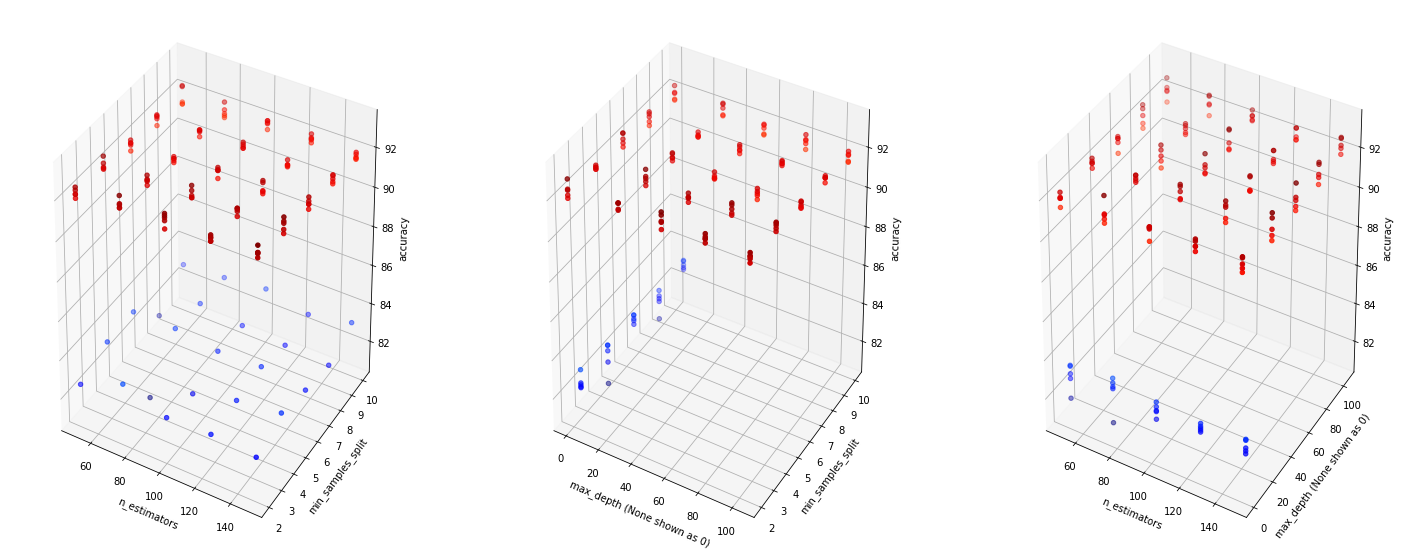

In [ ]:
fig = plt.figure(figsize=(25,10))

ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax3 = fig.add_subplot(1, 3, 3, projection='3d')

ax1.scatter3D(accuracy_Esp1['n_estimators'], accuracy_Esp1['min_samples_split'], accuracy_Esp1['accuracy'], c=accuracy_Esp1['accuracy'], cmap='jet');
ax1.set_xlabel('n_estimators')
ax1.set_ylabel('min_samples_split')
ax1.set_zlabel('accuracy');

ax2.scatter3D(accuracy_Esp1['max_depth_noNAN'], accuracy_Esp1['min_samples_split'], accuracy_Esp1['accuracy'], c=accuracy_Esp1['accuracy'], cmap='jet');
ax2.set_xlabel('max_depth (None shown as 0)')
ax2.set_ylabel('min_samples_split')
ax2.set_zlabel('accuracy');

ax3.scatter3D(accuracy_Esp1['n_estimators'], accuracy_Esp1['max_depth_noNAN'], accuracy_Esp1['accuracy'], c=accuracy_Esp1['accuracy'], cmap='jet');
ax3.set_xlabel('n_estimators')
ax3.set_ylabel('max_depth (None shown as 0)')
ax3.set_zlabel('accuracy');


Se nota lo que la opción que más influye al accuracy es max_depth. Para max_depth != None, pruebas de otros parametros dan resultado de 91% - 92% de accuracy. 

###Se repite aprendizaje con valores optimos para quedarse con este modelo

In [ ]:
model_RF_Esp1 = RandomForestClassifier(n_estimators = int(accuracy_Esp1['n_estimators'][optimalIndex_Esp1]),\
                                       max_depth = accuracy_Esp1['max_depth'][optimalIndex_Esp1],\
                                       min_samples_split = int(accuracy_Esp1['min_samples_split'][optimalIndex_Esp1]))
model_RF_Esp1.fit(x_Esp1_train, y_Esp1_train)

RandomForestClassifier(max_depth=55.0, n_estimators=150)

###Se visualiza la importancia de los features

0.   'Mineral Alt.306', 
1.   'TPH Molienda', 
1.   'TPH Molino 1', 
1.   'TPH Molino 2',
1.   'TPH Molino 3',
1.   'P80 Molino 1', 
1.   'P80 Molino 2', 
1.   'P80 Molino 3',
1.   'Flujo Más. Alim.',
1.   '% Alim. Total', 
1.   'Floculante GPT',
1.   'Prof. Agua Clara', 
1.   'Presión Cono', 
1.   'Balance Mineral', 
1.   'Cama', 
1.   'Barro', 
1.   'Interface'

In [ ]:
featI = pd.Series(model_RF_Esp1.feature_importances_).sort_values(ascending=False)
print(featI)

12    0.358299
11    0.163918
6     0.065752
13    0.057783
5     0.055167
7     0.052713
3     0.047719
8     0.047031
4     0.042390
1     0.041092
2     0.039472
9     0.028126
0     0.000477
10    0.000062
dtype: float64


Text(0.5, 0, 'Importancia de las features')

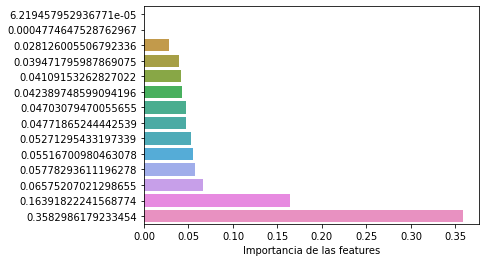

In [ ]:
sns.barplot(x=round(featI,4), y=featI, orient='h')
plt.xlabel('Importancia de las features')

Se ve muy claro que los atributos con más altaimportancia son 'Presión Cono' y 'Profundidad Agua Clara'. Los resultados confirman lo que se sabe sobre la física de la operación de los espesadores - agua clara influye fuerte a la distribución de mineral en el cono de espesador, y la presión cono tiene harta correlación con la medición de los sólidos de descarga.

###Se revisa las metricas del modelo

In [ ]:
target_names = ['ph{0}'.format(i) for i in DBEsp1['Torque & Sólidos Label'].unique()]

print(metrics.classification_report(y_Esp1_test, model_RF_Esp1.predict(x_Esp1_test), target_names=target_names))

              precision    recall  f1-score   support

         ph1       1.00      0.04      0.07        28
         ph0       0.94      0.58      0.71        26
        ph-2       0.93      0.84      0.88       286
         ph2       0.93      0.98      0.95      1472
        ph-1       0.88      0.81      0.84       216

    accuracy                           0.92      2028
   macro avg       0.94      0.65      0.69      2028
weighted avg       0.93      0.92      0.92      2028



Se nota lo que los mejores resultados de todos los indicadores se recibe prediciendo el set de datos con el mayor **support** - en este caso **ph2**.

Los casos de bajo soporte (**ph0** y **ph1**) presentan un alto nivel de precision - tiene un buena proporción entre las predicciones correctas y el total de predicciones. En el mismpo tiempo, los mismos casos (en particular el **ph1**) presentan bajos niveles de **recall** - tienen baja capacidad de distinguir casos positivos de negativos. En caso de **ph1** el valor es extremamente bajo, por lo tanto igual es extemamente bajo el valor de f1-score.

Los casos de **ph-1** y **ph-2** presentan un support promedio (ni bajo ni alto comparando con otros). Tanto precision, como recall y f1-score presentan niveles suficientes para ubicar el modelo para generar recomendaciones, como en el plan original.

Considerando lo que los mejores resultados se recibe para los datos de categoría **ph2**, los cuales tienen la cantidad más alta en comparación con los otros, está claro lo que para mejorar el rendimiento de otros grupos de datos, es necesario descargar un set de datos más amplio, con más largo el rango de fechas y con datos más diversos. 

##B. Datos de Espesador **2**

Como ya se ha comentado, esta parte del notebook se va a desarollar en el futuro.

#KNN

Se reusa la matriz de atributos, vector de label y la división entre set de testeo y entrenmiento preparado para Random Forest

##A. Espesador 1

In [ ]:
# x_Esp1_train, x_Esp1_test, y_Esp1_train, y_Esp1_test 

Se prepara las listas de valores para parametros n_neighbors, algorithm y leaf_size para probar los valores.

###Se revisa como influye cambio de n_neigbors, algorithm y leaf_size al accuracy

In [ ]:
kValues = list(range(2,100,5))
algorithms = ['auto', 'ball_tree', 'kd_tree', 'brute']
leafSizes = list(range(5,55,10))

totalLength = len(kValues)*len(algorithms)*len(leafSizes)

print('dimensiones de la lista de accuracy:', len(kValues), 'x', len(algorithms), 'x', len(leafSizes), '=', totalLength)

dimensiones de la lista de accuracy: 20 x 4 x 5 = 400


Se prepara listas para valores de los parametros y para accuracy

In [ ]:
list_n_neighbors = [] 
list_algorithm = [] 
list_leaf_size = [] 
list_accuracy = [] 

Se itera por listas con opciones del algoritmo, buscando accuracy maximo.

In [ ]:
i=1 # se inicia counter para el indicador del porgreso de las iteraciones por parametros

for k in kValues:
  for alg in algorithms:
    for leafSize in leafSizes:
      model_KNN_Esp1 = KNeighborsClassifier(n_neighbors=k, algorithm=alg, leaf_size=leafSize)
      model_KNN_Esp1.fit(x_Esp1_train, y_Esp1_train)
      y_Esp1_pred = model_KNN_Esp1.predict(x_Esp1_test)

      accuracy = metrics.accuracy_score(y_Esp1_test, y_Esp1_pred)*100

      list_n_neighbors.append(k)
      list_algorithm.append(alg) 
      list_leaf_size.append(leafSize)
      list_accuracy.append(accuracy)

# indicador del porgreso de las iteraciones por parametros
      if (i%10)==0:
        print('progress:', i*100/totalLength,'%')
      i+=1

progress: 2.5 %
progress: 5.0 %
progress: 7.5 %
progress: 10.0 %
progress: 12.5 %
progress: 15.0 %
progress: 17.5 %
progress: 20.0 %
progress: 22.5 %
progress: 25.0 %
progress: 27.5 %
progress: 30.0 %
progress: 32.5 %
progress: 35.0 %
progress: 37.5 %
progress: 40.0 %
progress: 42.5 %
progress: 45.0 %
progress: 47.5 %
progress: 50.0 %
progress: 52.5 %
progress: 55.0 %
progress: 57.5 %
progress: 60.0 %
progress: 62.5 %
progress: 65.0 %
progress: 67.5 %
progress: 70.0 %
progress: 72.5 %
progress: 75.0 %
progress: 77.5 %
progress: 80.0 %
progress: 82.5 %
progress: 85.0 %
progress: 87.5 %
progress: 90.0 %
progress: 92.5 %
progress: 95.0 %
progress: 97.5 %
progress: 100.0 %


Se crea un dataframe con los resultados de las iteraciones, en base de las listas de parametros y de accuracy.

In [ ]:
accuracyKNN_Esp1=pd.DataFrame(list(zip(list_n_neighbors,
                                       list_algorithm,
                                       list_leaf_size,
                                       list_accuracy)),
                              columns=[['n_neighbors', 'algorithm', 'leaf_size', 'accuracy']])

Se presenta los resultados de busqueda en forma numerica:

In [ ]:
maxaccuracy=np.max(accuracyKNN_Esp1['accuracy'])[0]
print('max accuracy obtenida:',maxaccuracy)

optimalIndex_Esp1 = accuracyKNN_Esp1['accuracy'].where(accuracyKNN_Esp1['accuracy']==maxaccuracy).dropna().iloc[0].name

print('\n\nconfiguración con max accuracy:\n===============================')
print('n_neighbors:', accuracyKNN_Esp1['n_neighbors'].iloc[optimalIndex_Esp1][0])
print('algorithm:', accuracyKNN_Esp1['algorithm'].iloc[optimalIndex_Esp1][0])
print('leaf_size:', accuracyKNN_Esp1['leaf_size'].iloc[optimalIndex_Esp1][0])
print('accuracy:', accuracyKNN_Esp1['accuracy'].iloc[optimalIndex_Esp1][0])

max accuracy obtenida: 89.39842209072978


configuración con max accuracy:
n_neighbors: 2
algorithm: auto
leaf_size: 5
accuracy: 89.39842209072978


In [ ]:
def algoToNum(row): 
  algorithm_code = {'auto': 0, 'ball_tree': 1, 'kd_tree': 2, 'brute': 3}
  return algorithm_code[row['algorithm']]

In [ ]:
accuracyKNN_Esp1['algorithm_code'] = accuracyKNN_Esp1.apply(lambda row: algoToNum(row), axis=1)

In [ ]:
accuracyKNN_Esp1.head()

,n_neighbors,algorithm,leaf_size,accuracy,algorithm_code
0,2,auto,5,89.398422,0
1,2,auto,15,89.398422,0
2,2,auto,25,89.398422,0
3,2,auto,35,89.398422,0
4,2,auto,45,89.398422,0


Se presenta los resultados de iteraciones por opciones del algoritmo en forma grafica:

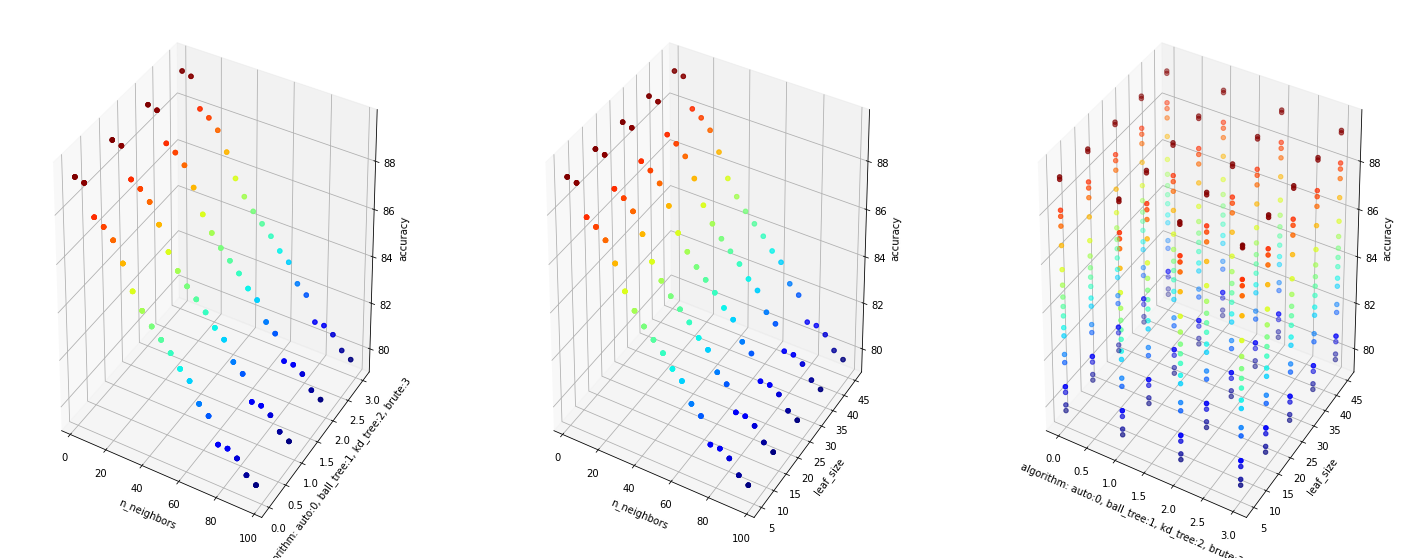

In [ ]:
fig = plt.figure(figsize=(25,10))

ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax3 = fig.add_subplot(1, 3, 3, projection='3d')

ax1.scatter3D(accuracyKNN_Esp1['n_neighbors'], accuracyKNN_Esp1['algorithm_code'], accuracyKNN_Esp1['accuracy'], c=accuracyKNN_Esp1['accuracy'], cmap='jet');
ax1.set_xlabel('n_neighbors')
ax1.set_ylabel('algorithm: auto:0, ball_tree:1, kd_tree:2, brute:3')
ax1.set_zlabel('accuracy');

ax2.scatter3D(accuracyKNN_Esp1['n_neighbors'], accuracyKNN_Esp1['leaf_size'], accuracyKNN_Esp1['accuracy'], c=accuracyKNN_Esp1['accuracy'], cmap='jet');
ax2.set_xlabel('n_neighbors')
ax2.set_ylabel('leaf_size')
ax2.set_zlabel('accuracy');

ax3.scatter3D(accuracyKNN_Esp1['algorithm_code'], accuracyKNN_Esp1['leaf_size'], accuracyKNN_Esp1['accuracy'], c=accuracyKNN_Esp1['accuracy'], cmap='jet');
ax3.set_xlabel('algorithm: auto:0, ball_tree:1, kd_tree:2, brute:3')
ax3.set_ylabel('leaf_size')
ax3.set_zlabel('accuracy');

De los gráficos se ve muy claro lo que el accuracy depende fuerte del valor de parametro n_neighbors. Cambios el algorithm y leaf_size no genera tanta diferencia en accuracy en comparación.

###Se repite el aprendizaje con valores optimos de parametros del algoritmo para quedarse con este modelo.

In [ ]:
model_KNN_Esp1 = KNeighborsClassifier(n_neighbors = accuracyKNN_Esp1['n_neighbors'].iloc[optimalIndex_Esp1][0],\
                                      algorithm = accuracyKNN_Esp1['algorithm'].iloc[optimalIndex_Esp1][0],\
                                      leaf_size = accuracyKNN_Esp1['leaf_size'].iloc[optimalIndex_Esp1][0])
model_KNN_Esp1.fit(x_Esp1_train, y_Esp1_train)

KNeighborsClassifier(leaf_size=5, n_neighbors=2)

###Se revisa las metricas del modelo

In [ ]:
target_names = ['ph{0}'.format(i) for i in DBEsp1['Torque & Sólidos Label'].unique()]

print(metrics.classification_report(y_Esp1_test, model_KNN_Esp1.predict(x_Esp1_test), target_names=target_names))

              precision    recall  f1-score   support

         ph1       0.51      0.75      0.61        28
         ph0       0.75      0.81      0.78        26
        ph-2       0.78      0.92      0.84       286
         ph2       0.93      0.93      0.93      1472
        ph-1       0.94      0.62      0.74       216

    accuracy                           0.89      2028
   macro avg       0.78      0.80      0.78      2028
weighted avg       0.90      0.89      0.89      2028



Tan como en el analisi del Random Forest, se nota lo que considerando todas las metricas, los mejores resultados se recibe prediciendo el set de datos con el mayor **support** - en este caso **ph2**.

El caso de **ph-1** presenta una buena precision de predicciones (tiene un buena proporción entre las predicciones correctas y el total de predicciones) pero el valor de recall por debajo de lo deseado (la capacidad de distinguir casos positivos de negativos no es suficiente). El f1-score está bajo por la razón de bajo recall.

El caso de **ph-2** es una situación opuesta de lo anterior: tiene un buen recall (sabe distinuir casos positivos de negativos), pero precision se presenta un poco por debajo de lo que se desea. En otras palabras, no tiene suficiente nivel de predicciones correctas sobre total de predicciones. El f1-score tiene un nivel aceptable, pero se considera la posibilidad para mejorarlo por subida de precision.

El caso de **ph0** no se presenta mal, considerando su muy bajo support. Tanto precision, como recall y f1-score presentan valores parecidos de los casos con soporte 10 veces más alto. Eso dicho, igual se puede mejorar el rendimiento por subida de support de esta categoria.

El **ph1** presenta una precision baja, con recall tabmién por debajo de lo buscado (en suma f1-score igual es bajo), lo que probablemente es un resultado de suppot muy bajo de esta categoria. 

Considerando lo que los mejores resultados se recibe para los datos de Así como en los resultados de Random forest, está claro lo que para mejorar el rendimiento de otros grupos de datos, es necesario descargar un set de datos más amplio, con más largo el rango de fechas y con datos más diversos - y de esta manera subir el support de las categorias de bajo soporte.

##B. Espesador 2

Como ya se ha comentado, esta parte del notebook se va a desarollar en el futuro.

#Analisis general de resultados obtenidos

Tan como en el miniproyecto 2, comparando solamente los resultados de accuracy entre los modelos obtenidos por Random Forest y KNN, el accuracy mayor se obtiene usando el Random Forest. 

El tema se está complicando si miramos los valores de prescision y recall de las categorías de bajo support. En este caso, el Random Forest da el recall de solo 4% al ph1, donde el KNN da el recall de 75%.

Se nota, que las predicciones de KNN están menos influídos por baja cantidad de datos de algunas de las categorías. 

En resumen, no se puede decir directamente cual de los algoritmos (entre RF y KNN) es mejor. Todo depende del set de datos y de lo que se busca en las prediciones. Casa caso hay que revisar de forma independiente.

#Plan de desarrollo del proyecto

Tan como se implicó en la introducción, este notebook se va a seguir desarrollando como un proyecto en el trabajo. 

La meta final, para el futuro:
* preparar modelos de buena calidad (con valores aceptables de todas las metricas aplicadas) de ambos espesadores de relaves,
* utilizar los modelos para generar recomendaciones de control de los SetPoint de **_Profundidad Agua Clara_** y **_GPT de Floculante_** para los lazos de contror implementados en los sistemas de control y de control avanzado de la planta concentradora.

Para los modelos que se quiere obtener a traves este notebook, tal como ya se ha implicado, se va a extender el rango de fechas para obtener más datos de las categorías cuales actualmente dienen bajo soporte. Se va a repetir el entrenamiento con el set de datos más grande, revisando cual de los algoritmos da resultados mejores en todas las metricas de calidad del modelo. Con esos datos obtenidos en el Espesador 1, se va a generar también un modelo para el Espesador 2.